## STF Validation

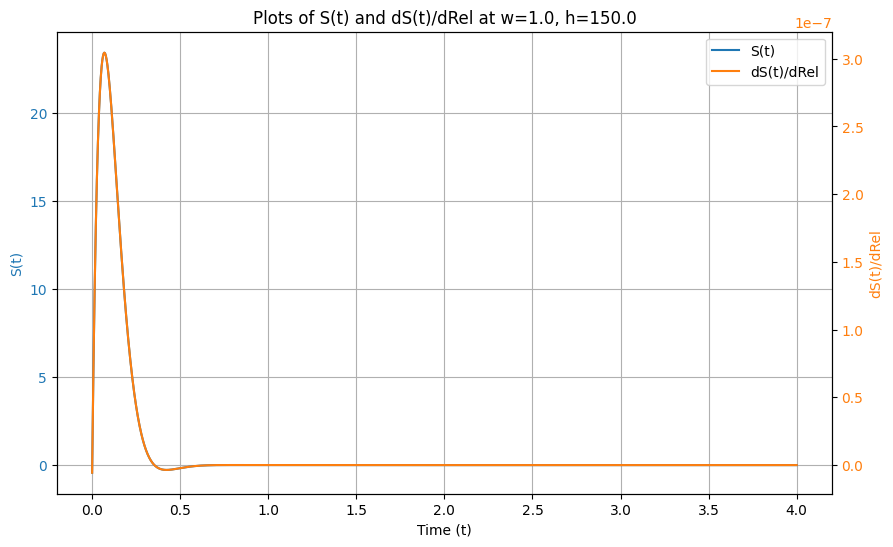

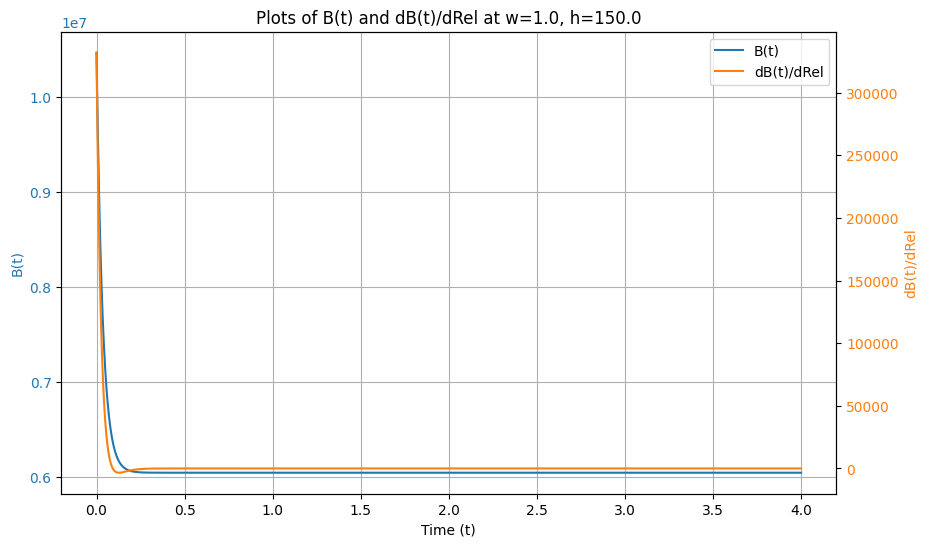

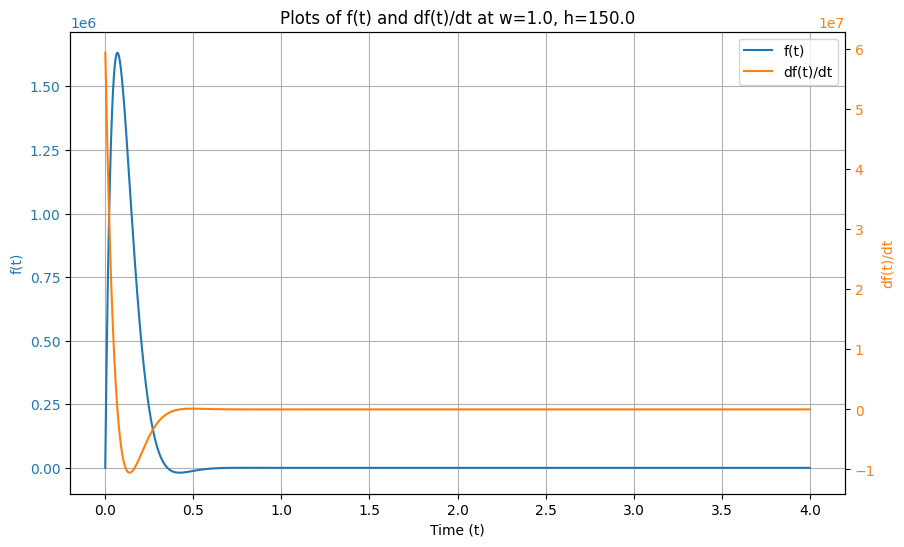

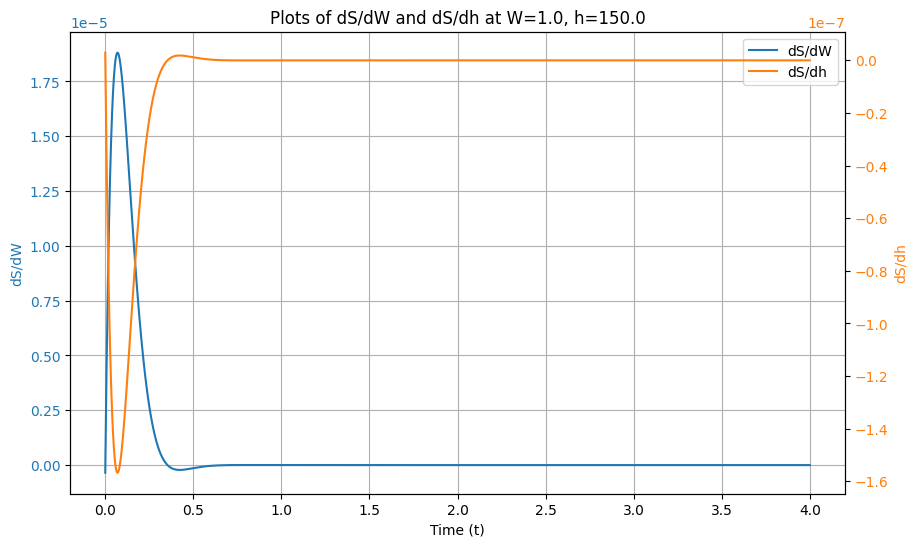

Analytical
dS/dW: 0.0029117874801158905
dS/dh: -2.4264892999781296e-05
Numerical
dS/dW: -1208.9931640625
dS/dh: 10.074943542480469
{'dS_dW_ana': Array([-3.4789778e-07,  3.4497955e-07,  1.0205385e-06, ...,
       -1.9868685e-28, -1.3294038e-28, -6.6702260e-29], dtype=float32), 'dS_dh_ana': Array([ 2.8991478e-09, -2.8748293e-09, -8.5044878e-09, ...,
        1.6557237e-30,  1.1078364e-30,  5.5585216e-31], dtype=float32), 'df_dt': Array([9.2668734e-02, 9.0352505e-02, 8.8072672e-02, ..., 8.7932503e-24,
       8.8590026e-24, 8.9210812e-24], dtype=float32), 'S_t': Array([-4.3342811e-01,  4.2980048e-01,  1.2714529e+00, ...,
       -2.4753615e-22, -1.6562518e-22, -8.3101725e-23], dtype=float32), 'f_t': Array([ 0.0000000e+00,  5.9374094e+04,  1.1725715e+05, ...,
       -7.8864326e-16, -7.8291769e-16, -7.7714950e-16], dtype=float32), 'B_t': Array([10468830. , 10345132. , 10224891. , ...,  6042600.5,  6042600.5,
        6042600.5], dtype=float32), 't': Array([0.0000000e+00, 1.0002501e-03, 2.000500

In [4]:
import jax
import jax.numpy as jnp
import jax.scipy.signal
from jax import grad, jit, vmap
import matplotlib.pyplot as plt

# Define the dictionary with constants for each material
constants_dict = {
    "Tuff/Rhyolite": {
        "h0": 122.0, "R0": 202.0, "gamma0": 26.0, "P10": 3.6E6, "P20": 5.0E6,
        "pv": 3500.0, "sv": 2021.0, "n": 2.4, "rho": 2000.0
    },
    "Granite": {
        "h0": 122.0, "R0": 321.0, "gamma0": 34.0, "P10": 4.6E6, "P20": 2.4E6,
        "pv": 5500.0, "sv": 3175.0, "n": 2.4, "rho": 2550.0
    },
    "Salt": {
        "h0": 122.0, "R0": 478.0, "gamma0": 31.0, "P10": 5.5E6, "P20": 0.8E6,
        "pv": 4670.0, "sv": 2696.0, "n": 1.87, "rho": 2200.0
    },
    "Shale": {
        "h0": 122.0, "R0": 265.0, "gamma0": 42.0, "P10": 4.2E6, "P20": 2.5E6,
        "pv": 4320.0, "sv": 2495.0, "n": 2.4, "rho": 2350.0
    },
    "Wet Tuff": {
        "h0": 122.0, "R0": 202.0, "gamma0": 26.0, "P10": 3.6E6, "P20": 5.0E6,
        "pv": 2400.0, "sv": 1300.0, "n": 2.4, "rho": 1915.0
    },
    "Wet Granite": {
        "h0": 122.0, "R0": 321.0, "gamma0": 34.0, "P10": 4.6E6, "P20": 2.4E6,
        "pv": 5350.0, "sv": 2795.0, "n": 2.4, "rho": 2650.0
    }
}

# Function to populate variables from the dictionary based on material name
def get_constants(material_name):
    if material_name in constants_dict:
        material_constants = constants_dict[material_name]
        h0 = jnp.array(material_constants["h0"])
        R0 = jnp.array(material_constants["R0"])
        gamma0 = jnp.array(material_constants["gamma0"])
        P10 = jnp.array(material_constants["P10"])
        P20 = jnp.array(material_constants["P20"])
        pv = jnp.array(material_constants["pv"])
        sv = jnp.array(material_constants["sv"])
        n = jnp.array(material_constants["n"])
        rho = jnp.array(material_constants["rho"])
        return h0, R0, gamma0, P10, P20, pv, sv, n, rho
    else:
        raise ValueError(f"Material '{material_name}' not found in the constants dictionary.")

def compute_partial_derivatives(w=1.0, h=150.0, material='Tuff/Rhyolite', plot=False):
    h0, R0, gamma0, P10, P20, pv, sv, n, rho = get_constants(material)
    mu = rho * sv ** 2
    lam = rho * pv ** 2 - 2 * mu
    h = jnp.array(h)
    w = jnp.array(w)
    t = jnp.linspace(0, 4.0, num=4000)

    def Heaviside(t):
        return jnp.where(t >= 0, 1.0, 0.0)

    H_t = Heaviside(t)
    R_el = R0 * (h0 / h) ** (1 / n) * w ** (1 / 3)
    gamma = gamma0 * (R0 / R_el)
    beta = (lam + 2 * mu) / (4 * mu)
    w0 = pv / R_el
    alpha = w0 / (2 * beta)
    p = w0 * jnp.sqrt(1 / (2 * beta) - 1 / (4 * beta ** 2))

    # Define f(t) based on equation (3)
    def f_t(R_el, t):
        return (R_el / (4 * alpha)) * (pv ** 2 / (beta * p)) * H_t * jnp.exp(-alpha * t) * jnp.sin(p * t)

    def df_t_dt(R_el, mu, pv, beta, p, alpha, t):
        A = (R_el / (4 * mu)) * (pv ** 2 / (beta * p))
        return A * H_t * jnp.exp(-alpha * t) * (-alpha * jnp.sin(p * t) + p * jnp.cos(p * t))

    f_t_val = f_t(R_el, t)
    df_dt = df_t_dt(R_el, mu, pv, beta, p, alpha, t)

    # Define B(t) based on equation (2)
    def B_t(R_el, t):
        P0_t = P10 * (h / h0)  # P1 - P2 with P1 and P2
        P2_t = P20 * (h0 / h) ** (1 / 3) * (R0 / R_el) ** 3 * w ** 0.87
        return (jnp.exp(-gamma * t) * P0_t + P2_t) * H_t

    B_t_val = B_t(R_el, t)
    df_dt_div = -df_dt / (R_el * pv)

    # Compute S(t) via convolution
    S_t_full = jax.scipy.signal.convolve(df_dt_div, B_t_val, mode='full')
    S_t = S_t_full[t.size - 1: t.size * 2 - 1]  # Ensure S_t has the same length as t

    # Compute analytical derivatives
    def dB_t_dRel_new(R_el, t):
        term1 = -jnp.exp(-gamma * t) * P10 * (h / h0) * (
            t * gamma / R_el - n / R_el * (h / h0) ** (1 / n)
        ) * (h * w ** (-1 / 3)) ** (1 / 3)
        term2 = P20 * w ** 0.87 * (
            (t * jnp.exp(-gamma * t) * R0 ** 3) / R_el ** 4 * (h0 / h) ** (1 / 3)
            - (t * jnp.exp(-gamma * t) * R0 ** 3) / R_el ** 4 * (h0 / h) ** (1 / 3)
        )
        term3 = (1 - jnp.exp(-gamma * t)) * (
            1 / 3 * n * R0 ** 2 / R_el ** 3 * (h0 / h) ** (1 / 3)
            * w ** (-2 / 3) * (h * w ** (-1 / 3)) ** (1 / 3)
        )
        term4 = (1 - jnp.exp(-gamma * t)) * (
            -3 * R0 ** 3 / R_el ** 4 * (h0 / h) ** (1 / 3)
            * (h * w ** (-1 / 3)) ** (1 / 3)
        )
        return (term1 + term2 + term3 + term4) * H_t

    dB_t_dRel_val = dB_t_dRel_new(R_el, t)
    dS_t_dRel_full = jax.scipy.signal.convolve(-df_dt_div, dB_t_dRel_val, mode='full')
    dS_t_dRel = dS_t_dRel_full[t.size - 1: t.size * 2 - 1]

    def dRel_dw(R0, h0, h, n, w):
        return R0 * (h0 / h) ** (1 / n) * (1 / 3) * w ** (-2 / 3)

    def dRel_dh(R0, h0, h, n, w):
        return -R0 * (1 / n) * (h0 / h) ** (1 / n) * (1 / h) * w ** (1 / 3)

    dS_dW_ana = dS_t_dRel * dRel_dw(R0, h0, h, n, w)
    dS_dh_ana = dS_t_dRel * dRel_dh(R0, h0, h, n, w)

    # Compute numerical derivatives
    def S_t_sum(w, h):
        R_el = R0 * (h0 / h) ** (1 / n) * w ** (1 / 3)
        gamma = gamma0 * (R0 / R_el)
        beta = (lam + 2 * mu) / (4 * mu)
        w0 = pv / R_el
        alpha = w0 / (2 * beta)
        p = w0 * jnp.sqrt(1 / (2 * beta) - 1 / (4 * beta ** 2))
        df_dt = df_t_dt(R_el, mu, pv, beta, p, alpha, t)
        B_t_val = B_t(R_el, t)
        df_dt_div = -df_dt / (R_el * pv)
        S_t_full = jax.scipy.signal.convolve(df_dt_div, B_t_val, mode='full')
        S_t = S_t_full[t.size - 1: t.size * 2 - 1]
        return S_t.sum()

    dS_dW_num = grad(S_t_sum, argnums=0)(w, h)
    dS_dh_num = grad(S_t_sum, argnums=1)(w, h)

    # Prepare data for plotting
    t_cpu = jnp.array(t)
    S_t_cpu = jnp.array(S_t)
    B_t_cpu = jnp.array(B_t_val)
    f_t_cpu = jnp.array(f_t_val)
    dB_t_dRel_cpu = jnp.array(dB_t_dRel_val)
    dS_t_dRel_cpu = jnp.array(dS_t_dRel)
    dS_dW_ana_cpu = jnp.array(dS_dW_ana)
    dS_dh_ana_cpu = jnp.array(dS_dh_ana)

    # Compute df_dt_num using constant spacing
    dt = t[1] - t[0]
    df_dt_num = jnp.gradient(f_t_val, dt)

    if plot:
        # Plot S(t) and dS(t)/dRel
        fig, ax1 = plt.subplots(figsize=(10, 6))
        plt.grid(True)
        ax1.plot(t_cpu, S_t_cpu, label='S(t)', color='tab:blue')
        ax1.set_xlabel('Time (t)')
        ax1.set_ylabel('S(t)', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax1.twinx()
        ax2.plot(t_cpu, dS_t_dRel_cpu, label='dS(t)/dRel', color='tab:orange')
        ax2.set_ylabel('dS(t)/dRel', color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')

        # Combine legends
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

        plt.title(f'Plots of S(t) and dS(t)/dRel at w={w}, h={h}')
        plt.show()

        # Plot B(t) and dB(t)/dRel
        fig, ax1 = plt.subplots(figsize=(10, 6))
        plt.grid(True)
        ax1.plot(t_cpu, B_t_cpu, label='B(t)', color='tab:blue')
        ax1.set_xlabel('Time (t)')
        ax1.set_ylabel('B(t)', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax1.twinx()
        ax2.plot(t_cpu, dB_t_dRel_cpu, label='dB(t)/dRel', color='tab:orange')
        ax2.set_ylabel('dB(t)/dRel', color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')

        # Combine legends
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

        plt.title(f'Plots of B(t) and dB(t)/dRel at w={w}, h={h}')
        plt.show()

        # Plot f(t) and df(t)/dt
        fig, ax1 = plt.subplots(figsize=(10, 6))
        plt.grid(True)
        ax1.plot(t_cpu, f_t_cpu, label='f(t)', color='tab:blue')
        ax1.set_xlabel('Time (t)')
        ax1.set_ylabel('f(t)', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax1.twinx()
        ax2.plot(t_cpu, df_dt_num, label='df(t)/dt', color='tab:orange')
        ax2.set_ylabel('df(t)/dt', color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')

        # Combine legends
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

        plt.title(f'Plots of f(t) and df(t)/dt at w={w}, h={h}')
        plt.show()

        # Plot dS/dW and dS/dh
        fig, ax1 = plt.subplots(figsize=(10, 6))
        plt.grid(True)
        ax1.plot(t_cpu, dS_dW_ana_cpu, label='dS/dW', color='tab:blue')
        ax1.set_xlabel('Time (t)')
        ax1.set_ylabel('dS/dW', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax1.twinx()
        ax2.plot(t_cpu, dS_dh_ana_cpu, label='dS/dh', color='tab:orange')
        ax2.set_ylabel('dS/dh', color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')

        # Combine legends
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

        plt.title(f'Plots of dS/dW and dS/dh at W={w}, h={h}')
        plt.show()

        print('Analytical')
        print(f'dS/dW: {dS_dW_ana.sum()}')
        print(f'dS/dh: {dS_dh_ana.sum()}')
        print('Numerical')
        print(f'dS/dW: {dS_dW_num}')
        print(f'dS/dh: {dS_dh_num}')

    out = {
        'dS_dW_ana': dS_dW_ana_cpu,
        'dS_dh_ana': dS_dh_ana_cpu,
        'df_dt': df_dt,
        'S_t': S_t_cpu,
        'f_t': f_t_cpu,
        'B_t': B_t_cpu,
        't': t_cpu,
        'dB_t_dRel': dB_t_dRel_cpu,
        'dS_t_dRel': dS_t_dRel_cpu,
        'R_el*pv': (R_el * pv),
        'h': h,
        'w': w
    }

    return out

# Example usage
plot = True
material = 'Tuff/Rhyolite'  # Options: Tuff/Rhyolite, Granite, Salt, Shale, Wet Tuff, Wet Granite
result = compute_partial_derivatives(w=1.0, h=150.0, material=material, plot=plot)

# Display the result
print(result)


## PINN Implementation (Validated)

100%|██████████| 5000/5000 [02:14<00:00, 37.06it/s, Total Loss=0.00407, LR=1e-6, Data Loss=0.0016, dS/dW Loss=0.000687, dS/dh Loss=0.00177]      


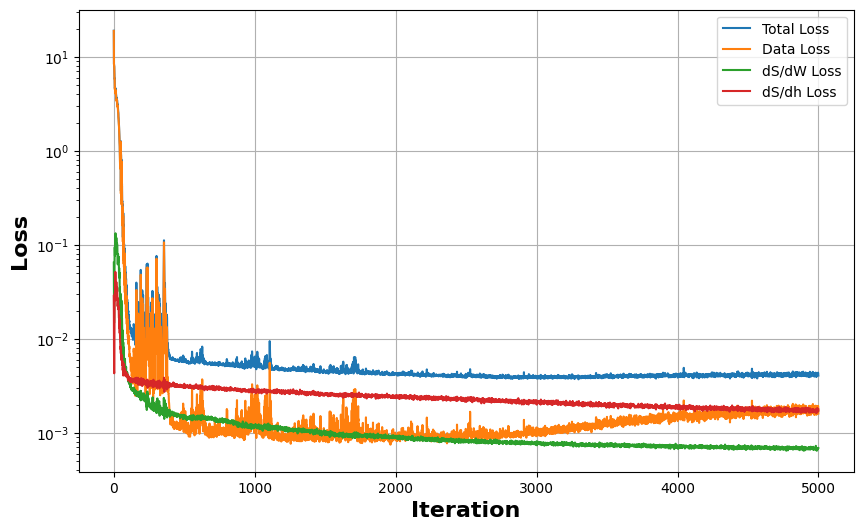

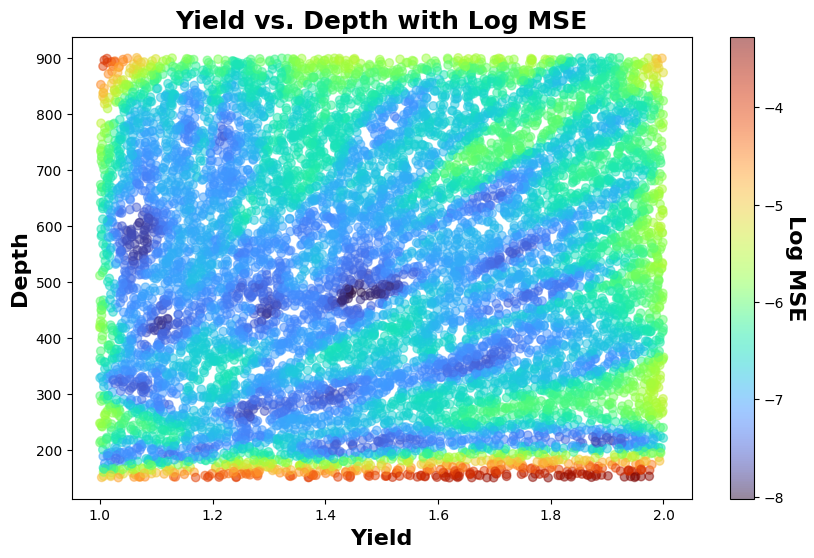

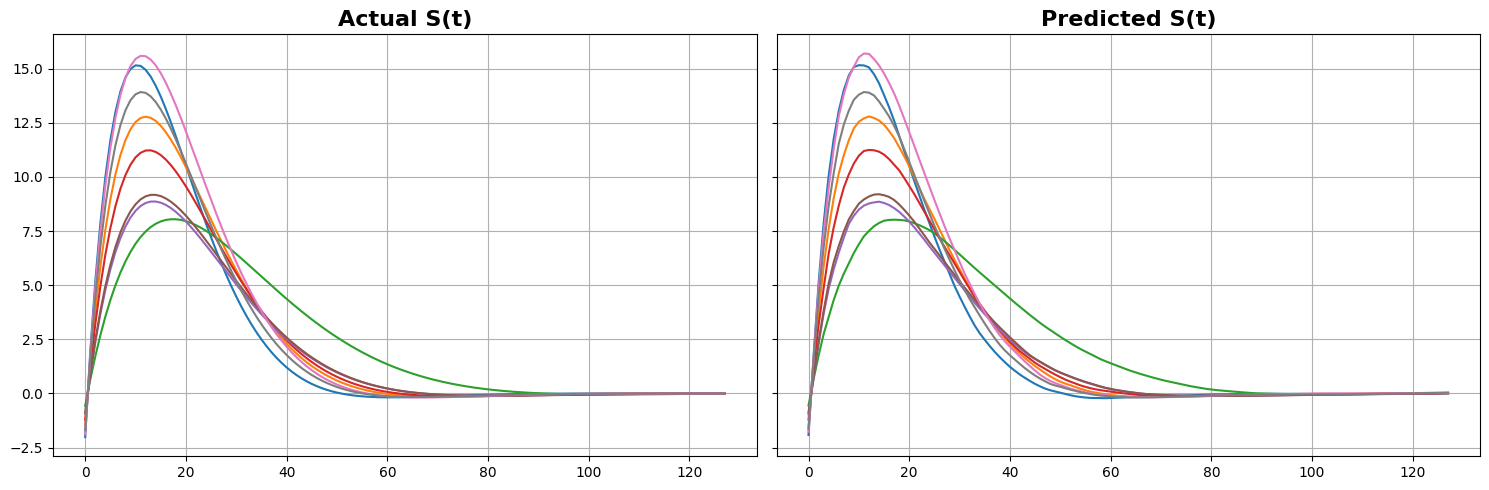

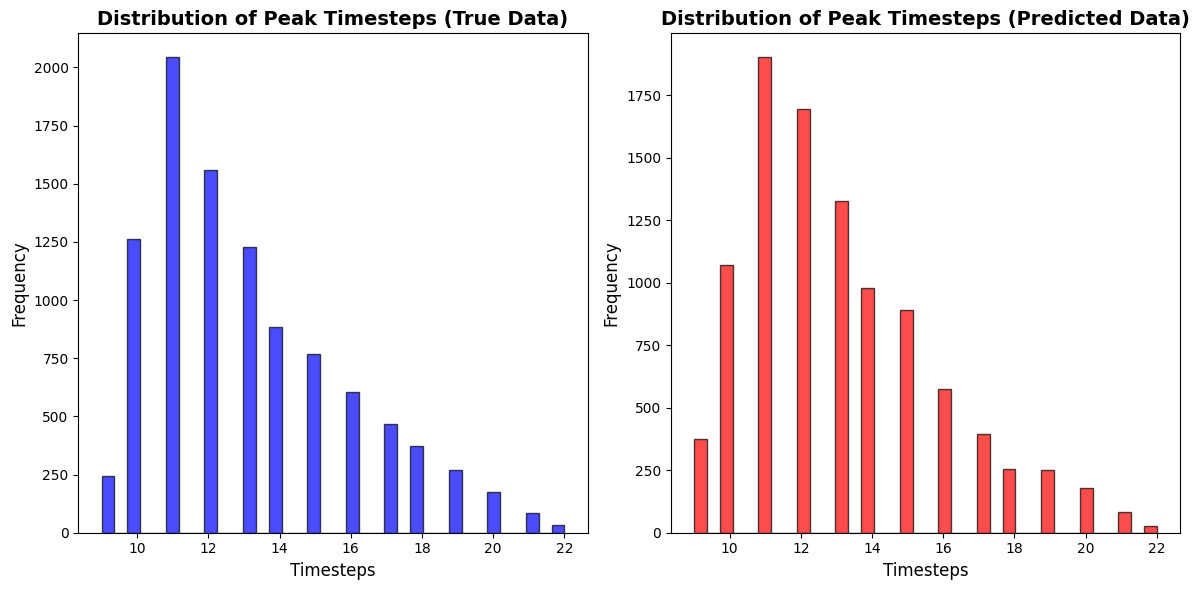

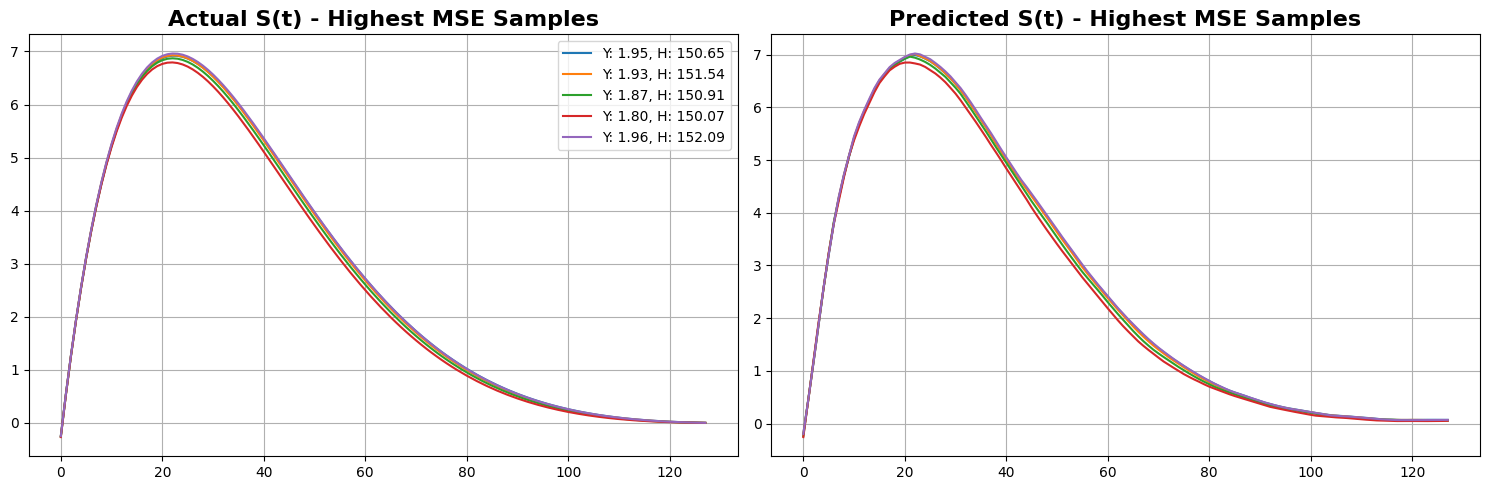

In [5]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax
from optax import tree_utils as otu
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

# Update JAX configuration
jax.config.update("jax_enable_x64", False)

# Set the random seed
base_seed = 42
key = jax.random.PRNGKey(base_seed)
np.random.seed(base_seed)

# Define the dictionary with constants for each material
constants_dict = {
    "Tuff/Rhyolite": {
        "h0": 122.0, "R0": 202.0, "gamma0": 26.0, "P10": 3.6e6, "P20": 5.0e6,
        "pv": 3500.0, "sv": 2021.0, "n": 2.4, "rho": 2000.0
    },
    "Granite": {
        "h0": 122.0, "R0": 321.0, "gamma0": 34.0, "P10": 4.6e6, "P20": 2.4e6,
        "pv": 5500.0, "sv": 3175.0, "n": 2.4, "rho": 2550.0
    }
}

# Function to retrieve constants for a material
def get_constants(material_name):
    if material_name in constants_dict:
        material_constants = constants_dict[material_name]
        # Convert constants to JAX arrays with dtype float32
        return {key: jnp.array(value, dtype=jnp.float32) for key, value in material_constants.items()}
    else:
        raise ValueError(f"Material '{material_name}' not found in the constants dictionary.")

# Set the material and get constants
material = 'Tuff/Rhyolite'
constants = get_constants(material)

# Define the Neural Network class using Flax
class NeuralNet(nn.Module):
    input_dimension: int
    output_dimension: int
    n_hidden_layers: int
    neurons: int
    activation: callable
    regularization_param: float
    regularization_exp: float

    def setup(self):
        # Use LeCun uniform initializer for tanh activation
        kernel_init = nn.initializers.lecun_uniform()
        bias_init = nn.initializers.zeros

        # Layers
        self.input_layer = nn.Dense(
            self.neurons, kernel_init=kernel_init, bias_init=bias_init)
        self.hidden_layers = [
            nn.Dense(self.neurons, kernel_init=kernel_init, bias_init=bias_init)
            for _ in range(self.n_hidden_layers - 1)
        ]
        self.output_layer = nn.Dense(
            self.output_dimension, kernel_init=kernel_init, bias_init=bias_init)

    def __call__(self, x):
        x = self.activation(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        return self.output_layer(x)

    def l2_regularization(self):
        params = self.get_variable('params', 'kernel')
        reg_loss = 0.0
        for param in jax.tree_leaves(params):
            reg_loss += jnp.sum(jnp.abs(param) ** self.regularization_exp)
        return self.regularization_param * reg_loss

# Create the compute_stf_batch function with constants embedded
def make_compute_stf_batch(constants):
    h0 = constants['h0']
    R0 = constants['R0']
    gamma0 = constants['gamma0']
    P10 = constants['P10']
    P20 = constants['P20']
    pv = constants['pv']
    sv = constants['sv']
    n = constants['n']
    rho = constants['rho']

    @jax.jit
    def compute_stf_batch(w, h, t):
        mu = rho * sv ** 2
        lam = rho * pv ** 2 - 2 * mu

        # Compute R_el, gamma, beta, etc.
        h_ratio = h0 / h
        w_power = w ** (1 / 3)
        R_el = R0 * h_ratio ** (1 / n) * w_power
        gamma = gamma0 * (R0 / R_el)
        beta = (lam + 2 * mu) / (4 * mu)
        w0 = pv / R_el
        alpha = w0 / (2 * beta)
        sqrt_term = jnp.sqrt(1 / (2 * beta) - 1 / (4 * beta ** 2))
        p = w0 * sqrt_term

        exp_alpha_t = jnp.exp(-alpha * t)
        sin_p_t = jnp.sin(p * t)
        cos_p_t = jnp.cos(p * t)
        exp_gamma_t = jnp.exp(-gamma * t)
        H_t = jnp.where(t >= 0, 1.0, 0.0)

        # Compute f(t) and its derivative df/dt
        pv_squared = pv ** 2
        beta_p = beta * p
        f_prefactor = (R_el / (4 * alpha)) * (pv_squared / beta_p)
        f_t_val = f_prefactor * exp_alpha_t * sin_p_t * H_t

        A = (R_el / (4 * mu)) * (pv_squared / beta_p)
        df_dt = A * exp_alpha_t * (-alpha * sin_p_t + p * cos_p_t) * H_t

        # Compute B(t)
        P0_t = P10 * (h / h0)
        h_ratio_third = h_ratio ** (1 / 3)
        R_ratio_cubed = (R0 / R_el) ** 3
        P2_t = P20 * h_ratio_third * R_ratio_cubed * w ** 0.87
        B_t_val = (exp_gamma_t * P0_t + P2_t) * H_t

        df_dt_div = -df_dt / (R_el * pv)

        # Convolution
        S_t = jax.vmap(lambda a, b: jnp.convolve(a, b, mode='full'))(df_dt_div, B_t_val)
        S_t = S_t[:, t.shape[1] - 1: t.shape[1] * 2 - 1]

        # Analytical derivatives
        gamma_over_Rel = gamma / R_el
        n_over_Rel = n / R_el
        term1 = -exp_gamma_t * P10 * (h / h0) * (
            t * gamma_over_Rel - n_over_Rel * h_ratio ** (1 / n)
        ) * (h * w ** (-1 / 3)) ** (1 / 3)
        term3 = (1 - exp_gamma_t) * (
            (1 / 3) * n * R0 ** 2 / R_el ** 3 * h_ratio_third * w ** (-2 / 3) * (h * w ** (-1 / 3)) ** (1 / 3)
        )
        term4 = (1 - exp_gamma_t) * (
            -3 * R0 ** 3 / R_el ** 4 * h_ratio_third * (h * w ** (-1 / 3)) ** (1 / 3)
        )
        dB_t_dRel = (term1 + term3 + term4) * H_t
        
        dS_t_dRel = jax.vmap(lambda a, b: jnp.convolve(a, b, mode='full'))(-df_dt_div, dB_t_dRel)
        dS_t_dRel = dS_t_dRel[:, t.shape[1] - 1: t.shape[1] * 2 - 1]

        # Derivatives of R_el
        dRel_dw = R_el / (3 * w)
        dRel_dh = -R_el / (n * h)

        dS_dW_ana = dS_t_dRel * dRel_dw
        dS_dh_ana = dS_t_dRel * dRel_dh

        return S_t, dS_dW_ana, dS_dh_ana

    return compute_stf_batch

# Create the compute_stf_batch function with constants embedded
compute_stf_batch = make_compute_stf_batch(constants)

# Generate batch function without passing 'material'
def generate_batch(key, b, nt, hmin, hmax, wmin, wmax, tmin, tmax, progress=0.25):
    key, subkey = jax.random.split(key)
    
    # Compute current max values based on progress
    h_current_max = hmin + progress * (hmax - hmin)
    w_current_max = wmin + progress * (wmax - wmin)
    
    # Sample h and w from current range
    h = jax.random.uniform(subkey, shape=(b, 1), minval=hmin, maxval=h_current_max)
    key, subkey = jax.random.split(key)
    w = jax.random.uniform(subkey, shape=(b, 1), minval=wmin, maxval=w_current_max)
    t = jnp.linspace(tmin, tmax, nt)
    t = jnp.tile(t, (b, 1))  # Shape (b, nt)

    # Compute STF and derivatives
    S_t, dS_dW, dS_dh = compute_stf_batch(w, h, t)

    hnorm = (h / hmax).squeeze()        # Shape (b,)
    wnorm = (w / wmax).squeeze()        # Shape (b,)
    tnorm = t / tmax                    # Shape (b, nt)
    tnorm_flat = tnorm.flatten()        # Shape (b * nt,)

    # Prepare input x
    x = jnp.stack((
        tnorm_flat,                    # Shape (b * nt,)
        jnp.repeat(wnorm, nt),         # Shape (b * nt,)
        jnp.repeat(hnorm, nt)          # Shape (b * nt,)
    ), axis=-1)

    # Compute smax and smin
    smax = jnp.max(S_t, axis=1, keepdims=True)  # Shape (b, 1)
    smin = jnp.min(S_t, axis=1, keepdims=True)  # Shape (b, 1)

    # Repeat smax and smin along the time axis to match (b, nt)
    smax = jnp.tile(smax, (1, nt)).flatten()    # Shape (b * nt,)
    smin = jnp.tile(smin, (1, nt)).flatten()    # Shape (b * nt,)

    # Flatten S_t and derivatives
    S_t_flat = S_t.flatten()         # Shape (b * nt,)
    dS_dW_flat = dS_dW.flatten()     # Shape (b * nt,)
    dS_dh_flat = dS_dh.flatten()     # Shape (b * nt,)

    # Compute per-sample xmax and xmin
    xmax = jnp.max(x, axis=0, keepdims=True)  # Shape (1, 3)
    xmin = jnp.min(x, axis=0, keepdims=True)  # Shape (1, 3)

    # Prepare batch data
    batch = (
        x,                 # Shape (b * nt, 3)
        S_t_flat,          # Shape (b * nt,)
        smax,              # Shape (b * nt,)
        smin,              # Shape (b * nt,)
        xmax,              # Shape (1, 3)
        xmin,              # Shape (1, 3)
        dS_dW_flat,        # Shape (b * nt,)
        dS_dh_flat         # Shape (b * nt,)
    )

    return key, batch

# Training parameters
b = 512
nt = 128
tmax = 0.5
tmin = 0.0
n_iter = 5000

hmin = 150.0
hmax = 900.0
wmin = 1.0
wmax = 2.0

lam_w = 1e-4
lam_h = 1e-4
lam_d = 1e-0

# Create the model
model = NeuralNet(
    input_dimension=3,
    output_dimension=1,
    n_hidden_layers=6,
    neurons=256,
    activation=nn.relu,
    regularization_param=0.5,
    regularization_exp=2.0,
)

# Initialize model parameters
key, subkey = jax.random.split(key)
dummy_input = jnp.ones((1, 3), dtype=jnp.float32)
params = model.init(subkey, dummy_input)

# Define optimizer and scheduler
initial_learning_rate = 1e-3

optimizer = optax.chain(
    optax.adam(initial_learning_rate),
        optax.contrib.reduce_on_plateau(
        patience=100,
        cooldown=100,
        factor=0.5,
        rtol=0.0001,
        accumulation_size=1,
        min_scale = 1e-3,
    ),
)
opt_state = optimizer.init(params)

# Define the loss function
def loss_fn(params, batch):
    x, S_t, smax, smin, xmax, xmin, dS_dW, dS_dh = batch
    # Forward pass
    s = model.apply(params, (x - xmin) / (xmax - xmin))
    s = s.squeeze() * (smax - smin) + smin



    # Data loss
    loss_d = lam_d * jnp.mean((s - S_t) ** 2)

    # Compute gradients w.r.t x
    def s_fn(x_i, smax_i, smin_i):
        x_i_norm = (x_i - xmin) / (xmax - xmin)
        s_i = model.apply(params, x_i_norm).squeeze() * (smax_i - smin_i) + smin_i
        return s_i

    # Vectorize gradient computation over all samples
    grad_s_x = jax.vmap(
        jax.grad(s_fn, argnums=0),
        in_axes=(0, 0, 0)
    )(x, smax, smin)

    # Extract gradients w.r.t wnorm and hnorm (x[:,1], x[:,2])
    grad_s_w = grad_s_x[:, 1]  # Gradient w.r.t wnorm
    grad_s_h = grad_s_x[:, 2]  # Gradient w.r.t hnorm

    # Derivative losses
    loss_sw = lam_w * jnp.mean((grad_s_w - dS_dW) ** 2)
    loss_sh = lam_h * jnp.mean((grad_s_h - dS_dh) ** 2)

    # Total loss
    total_loss = loss_d + loss_sw + loss_sh
    return total_loss, (loss_d, loss_sw, loss_sh)

@jax.jit
def train_step(params, opt_state, batch, step):
    (loss, losses), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, batch)
    updates, opt_state = optimizer.update(grads, opt_state, params, step=step, value=loss)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss, losses

# Pre-compile the train_step function
key, batch = generate_batch(key, b, nt, hmin, hmax, wmin, wmax, tmin, tmax)
params, opt_state, _, _ = train_step(params, opt_state, batch, 0)

# Training loop with progress bar
losses = []
loss_d_list = []
loss_sw_list = []
loss_sh_list = []
learning_rates = []

pbar = trange(n_iter)
for step in pbar:
    # Generate batch data
    progress = 0.25 + 0.75 * (step / n_iter)
    key, batch = generate_batch(key, b, nt, hmin, hmax, wmin, wmax, tmin, tmax, progress=progress)

    # Perform a training step
    params, opt_state, loss, (loss_d, loss_sw, loss_sh) = train_step(params, opt_state, batch, step)

    # Update loss lists
    losses.append(float(loss))
    loss_d_list.append(float(loss_d))
    loss_sw_list.append(float(loss_sw))
    loss_sh_list.append(float(loss_sh))

    # Get the current learning rate from the scheduler
    lr_scale = otu.tree_get(opt_state, "scale")
    current_lr = lr_scale * initial_learning_rate
    learning_rates.append(float(current_lr))

    # Update progress bar
    pbar.set_postfix({
        'Total Loss': float(loss),
        'LR': float(current_lr),
        'Data Loss': float(loss_d),
        'dS/dW Loss': float(loss_sw),
        'dS/dh Loss': float(loss_sh)
    })

# Plot losses
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(losses, label='Total Loss')
plt.plot(loss_d_list, label='Data Loss')
plt.plot(loss_sw_list, label='dS/dW Loss')
plt.plot(loss_sh_list, label='dS/dh Loss')
plt.yscale('log')
plt.xlabel('Iteration', fontsize=16, fontweight='bold')
plt.ylabel('Loss', fontsize=16, fontweight='bold')
plt.legend()
plt.show()


# Evaluate the model
b = 10000  # Batch size for evaluation

# Generate new h, w, t values for evaluation
key, subkey = jax.random.split(key)
h = jax.random.uniform(subkey, shape=(b, 1), minval=hmin, maxval=hmax)
key, subkey = jax.random.split(key)
w = jax.random.uniform(subkey, shape=(b, 1), minval=wmin, maxval=wmax)
t = jnp.linspace(tmin, tmax, nt)
t = jnp.tile(t, (b, 1))  # Shape (b, nt)

# Compute true S_t and analytical derivatives
S_t, dS_dW_ana, dS_dh_ana = compute_stf_batch(w, h, t)

# Normalize h, w, t
hnorm = (h / hmax).squeeze()  # Shape (b,)
wnorm = (w / wmax).squeeze()  # Shape (b,)
tnorm = t / tmax              # Shape (b, nt)

# Flatten tnorm
tnorm_flat = tnorm.flatten()  # Shape (b * nt,)

# Repeat hnorm and wnorm to match the time dimension
hnorm_flat = jnp.repeat(hnorm, nt)  # Shape (b * nt,)
wnorm_flat = jnp.repeat(wnorm, nt)  # Shape (b * nt,)

# Prepare input x by stacking tnorm_flat, wnorm_flat, and hnorm_flat
x = jnp.stack((tnorm_flat, wnorm_flat, hnorm_flat), axis=-1)  # Shape (b * nt, 3)

# Compute xmax and xmin over all data (consistent with training)
xmax = jnp.max(x, axis=0, keepdims=True)  # Shape (1, 3)
xmin = jnp.min(x, axis=0, keepdims=True)  # Shape (1, 3)

# Normalize x
x_normalized = (x - xmin) / (xmax - xmin)  # Shape (b * nt, 3)

# Compute smax and smin per sample
smax = jnp.max(S_t, axis=1, keepdims=True)  # Shape (b, 1)
smin = jnp.min(S_t, axis=1, keepdims=True)  # Shape (b, 1)

# Repeat smax and smin along the time dimension to match (b, nt)
smax = jnp.tile(smax, (1, nt)).flatten()  # Shape (b * nt,)
smin = jnp.tile(smin, (1, nt)).flatten()  # Shape (b * nt,)

# Evaluate the model
s_pred = model.apply(params, x_normalized)  # Shape (b * nt, 1)
s_pred = s_pred.squeeze()  # Shape (b * nt,)

# Apply inverse normalization to s_pred
s_pred = s_pred * (smax - smin) + smin  # Shape (b * nt,)

# Reshape s_pred and S_t to (b, nt) for comparison
s_pred = s_pred.reshape(b, nt)  # Shape (b, nt)
S_t = S_t.reshape(b, nt)        # Shape (b, nt)

# Compute MSE over time steps for each sample
mse = jnp.mean((S_t - s_pred) ** 2, axis=1)  # Shape (b,)

# Convert JAX arrays to NumPy arrays for plotting
w_np = np.array(w.squeeze())
h_np = np.array(h.squeeze())
mse_np = np.array(mse)
S_t_np = np.array(S_t)
s_pred_np = np.array(s_pred)

# Plot yield vs depth with MSE
fig = plt.figure(figsize=(10, 6))
plt.scatter(
    x=w_np,  # Yield values
    y=h_np,  # Depth values
    c=np.log(mse_np),  # Log of MSE for color mapping
    cmap='turbo',
    alpha=0.5
)
cbar = plt.colorbar()
cbar.set_label('Log MSE', rotation=270, fontsize=16, fontweight='bold')
cbar.ax.get_yaxis().labelpad = 15
plt.xlabel('Yield', fontsize=16, fontweight='bold')
plt.ylabel('Depth', fontsize=16, fontweight='bold')
plt.title('Yield vs. Depth with Log MSE', fontsize=18, fontweight='bold')
plt.show()

# Plot actual and predicted S(t)
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
for ax in axs:
    ax.grid(True)

axs[0].set_title('Actual S(t)', fontsize=16, fontweight='bold')
axs[1].set_title('Predicted S(t)', fontsize=16, fontweight='bold')

for i in range(8):
    axs[0].plot(S_t_np[i], alpha=1.)
    axs[1].plot(s_pred_np[i], alpha=1.)

plt.tight_layout()
plt.show()

# Find peaks for true and predicted data
true_peaks = np.argmax(S_t_np, axis=1)      # Shape (b,)
predicted_peaks = np.argmax(s_pred_np, axis=1)   # Shape (b,)

# Plot the distribution of peaks
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(true_peaks, bins='auto', color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Peak Timesteps (True Data)', fontsize=14, fontweight='bold')
plt.xlabel('Timesteps', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(1, 2, 2)
plt.hist(predicted_peaks, bins='auto', color='red', alpha=0.7, edgecolor='black')
plt.title('Distribution of Peak Timesteps (Predicted Data)', fontsize=14, fontweight='bold')
plt.xlabel('Timesteps', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

# Determine the number of samples to plot
N = 5  # You can adjust N to plot more or fewer samples

# Get indices of samples sorted by MSE in descending order
sorted_indices = np.argsort(mse_np)[::-1]

# Select the top N samples
top_indices = sorted_indices[:N]

# Plot actual and predicted S(t) for top N samples with highest MSE
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for ax in axs:
    ax.grid(True)

axs[0].set_title('Actual S(t) - Highest MSE Samples', fontsize=16, fontweight='bold')
axs[1].set_title('Predicted S(t) - Highest MSE Samples', fontsize=16, fontweight='bold')

for idx in top_indices:
    axs[0].plot(S_t_np[idx], label=f'Y: {w_np[idx]:.2f}, H: {h_np[idx]:.2f}')
    axs[1].plot(s_pred_np[idx], label=f'Y: {w_np[idx]:.2f}, H: {h_np[idx]:.2f}')

# Optionally, add legends to identify samples
axs[0].legend()
# axs[1].legend()

plt.tight_layout()
plt.show()# Plot actual and predicted S(t)
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
for ax in axs:
    ax.grid(True)

axs[0].set_title('Actual S(t)', fontsize=16, fontweight='bold')
axs[1].set_title('Predicted S(t)', fontsize=16, fontweight='bold')

for i in range(8):
    axs[0].plot(S_t_np[i], alpha=1.)
    axs[1].plot(s_pred_np[i], alpha=1.)

plt.tight_layout()
plt.show()

# Find peaks for true and predicted data
true_peaks = np.argmax(S_t_np, axis=1)      # Shape (b,)
predicted_peaks = np.argmax(s_pred_np, axis=1)   # Shape (b,)

# Plot the distribution of peaks
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(true_peaks, bins='auto', color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Peak Timesteps (True Data)', fontsize=14, fontweight='bold')
plt.xlabel('Timesteps', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(1, 2, 2)
plt.hist(predicted_peaks, bins='auto', color='red', alpha=0.7, edgecolor='black')
plt.title('Distribution of Peak Timesteps (Predicted Data)', fontsize=14, fontweight='bold')
plt.xlabel('Timesteps', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

# Determine the number of samples to plot
N = 5  # You can adjust N to plot more or fewer samples

# Get indices of samples sorted by MSE in descending order
sorted_indices = np.argsort(mse_np)[::-1]

# Select the top N samples
top_indices = sorted_indices[:N]

# Plot actual and predicted S(t) for top N samples with highest MSE
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for ax in axs:
    ax.grid(True)

axs[0].set_title('Actual S(t) - Highest MSE Samples', fontsize=16, fontweight='bold')
axs[1].set_title('Predicted S(t) - Highest MSE Samples', fontsize=16, fontweight='bold')

for idx in top_indices:
    axs[0].plot(S_t_np[idx], label=f'Y: {w_np[idx]:.2f}, H: {h_np[idx]:.2f}')
    axs[1].plot(s_pred_np[idx], label=f'Y: {w_np[idx]:.2f}, H: {h_np[idx]:.2f}')

# Optionally, add legends to identify samples
axs[0].legend()
# axs[1].legend()

plt.tight_layout()
plt.show()


## Grid search of loss penalties

In [5]:
import os
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state, checkpoints
import optax
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
import math
import pandas as pd  # For results analysis
import json

# Update JAX configuration
jax.config.update("jax_enable_x64", False)

# Set the random seed
base_seed = 42
key = jax.random.PRNGKey(base_seed)
np.random.seed(base_seed)

# Define the dictionary with constants for each material
constants_dict = {
    "Tuff/Rhyolite": {
        "h0": 122.0, "R0": 202.0, "gamma0": 26.0, "P10": 3.6e6, "P20": 5.0e6,
        "pv": 3500.0, "sv": 2021.0, "n": 2.4, "rho": 2000.0
    },
    "Granite": {
        "h0": 122.0, "R0": 321.0, "gamma0": 34.0, "P10": 4.6e6, "P20": 2.4e6,
        "pv": 5500.0, "sv": 3175.0, "n": 2.4, "rho": 2550.0
    },
    # Add other materials if needed
}

# Function to retrieve constants for a material
def get_constants(material_name):
    if material_name in constants_dict:
        material_constants = constants_dict[material_name]
        # Convert constants to JAX arrays with dtype float32
        return {key: jnp.array(value, dtype=jnp.float32) for key, value in material_constants.items()}
    else:
        raise ValueError(f"Material '{material_name}' not found in the constants dictionary.")

# Set the material and get constants
material = 'Tuff/Rhyolite'
constants = get_constants(material)

# Define the Neural Network class using Flax
class NeuralNet(nn.Module):
    input_dimension: int
    output_dimension: int
    n_hidden_layers: int
    neurons: int
    activation: callable
    regularization_param: float
    regularization_exp: float

    def setup(self):
        # Use LeCun uniform initializer for tanh activation
        kernel_init = nn.initializers.lecun_uniform()
        bias_init = nn.initializers.zeros

        # Layers
        self.input_layer = nn.Dense(
            self.neurons, kernel_init=kernel_init, bias_init=bias_init)
        self.hidden_layers = [
            nn.Dense(self.neurons, kernel_init=kernel_init, bias_init=bias_init)
            for _ in range(self.n_hidden_layers - 1)
        ]
        self.output_layer = nn.Dense(
            self.output_dimension, kernel_init=kernel_init, bias_init=bias_init)

    def __call__(self, x):
        x = self.activation(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        return self.output_layer(x)

    def l2_regularization(self):
        params = self.get_variable('params', 'kernel')
        reg_loss = 0.0
        for param in jax.tree_leaves(params):
            reg_loss += jnp.sum(jnp.abs(param) ** self.regularization_exp)
        return self.regularization_param * reg_loss

# Create the compute_stf_batch function with constants embedded
def make_compute_stf_batch(constants):
    h0 = constants['h0']
    R0 = constants['R0']
    gamma0 = constants['gamma0']
    P10 = constants['P10']
    P20 = constants['P20']
    pv = constants['pv']
    sv = constants['sv']
    n = constants['n']
    rho = constants['rho']

    def compute_stf_batch(w, h, t):
        mu = rho * sv ** 2
        lam = rho * pv ** 2 - 2 * mu

        # Compute R_el, gamma, beta, etc.
        h_ratio = h0 / h
        w_power = w ** (1 / 3)
        R_el = R0 * h_ratio ** (1 / n) * w_power
        gamma = gamma0 * (R0 / R_el)
        beta = (lam + 2 * mu) / (4 * mu)
        w0 = pv / R_el
        alpha = w0 / (2 * beta)
        sqrt_term = jnp.sqrt(1 / (2 * beta) - 1 / (4 * beta ** 2))
        p = w0 * sqrt_term

        exp_alpha_t = jnp.exp(-alpha * t)
        sin_p_t = jnp.sin(p * t)
        cos_p_t = jnp.cos(p * t)
        exp_gamma_t = jnp.exp(-gamma * t)
        H_t = jnp.where(t >= 0, 1.0, 0.0)

        # Compute f(t) and its derivative df/dt
        pv_squared = pv ** 2
        beta_p = beta * p
        f_prefactor = (R_el / (4 * alpha)) * (pv_squared / beta_p)
        f_t_val = f_prefactor * exp_alpha_t * sin_p_t * H_t

        A = (R_el / (4 * mu)) * (pv_squared / beta_p)
        df_dt = A * exp_alpha_t * (-alpha * sin_p_t + p * cos_p_t) * H_t

        # Compute B(t)
        P0_t = P10 * (h / h0)
        h_ratio_third = h_ratio ** (1 / 3)
        R_ratio_cubed = (R0 / R_el) ** 3
        P2_t = P20 * h_ratio_third * R_ratio_cubed * w ** 0.87
        B_t_val = (exp_gamma_t * P0_t + P2_t) * H_t

        df_dt_div = -df_dt / (R_el * pv)

        # Compute n_padded outside of JAX operations
        nt = t.shape[1]  # nt is known and static
        n_conv = 2 * nt - 1
        n_padded = 2 ** int(math.ceil(math.log2(n_conv)))

        # Define fft_convolve using n_padded
        def fft_convolve(a, b):
            A_f = jnp.fft.rfft(a, n=n_padded)
            B_f = jnp.fft.rfft(b, n=n_padded)
            C_f = A_f * B_f
            c = jnp.fft.irfft(C_f, n=n_padded)
            c = c[:n_conv]
            return c

        # FFT-based convolution
        S_t = jax.vmap(fft_convolve)(df_dt_div, B_t_val)
        S_t = S_t[:, nt - 1: 2 * nt - 1]

        # Analytical derivatives
        gamma_over_Rel = gamma / R_el
        n_over_Rel = n / R_el
        term1 = -exp_gamma_t * P10 * (h / h0) * (
            t * gamma_over_Rel - n_over_Rel * h_ratio ** (1 / n)
        ) * (h * w ** (-1 / 3)) ** (1 / 3)
        term3 = (1 - exp_gamma_t) * (
            (1 / 3) * n * R0 ** 2 / R_el ** 3 * h_ratio_third * w ** (-2 / 3) * (h * w ** (-1 / 3)) ** (1 / 3)
        )
        term4 = (1 - exp_gamma_t) * (
            -3 * R0 ** 3 / R_el ** 4 * h_ratio_third * (h * w ** (-1 / 3)) ** (1 / 3)
        )
        dB_t_dRel = (term1 + term3 + term4) * H_t

        dS_t_dRel = jax.vmap(fft_convolve)(df_dt_div, dB_t_dRel)
        dS_t_dRel = dS_t_dRel[:, nt - 1: 2 * nt - 1]

        # Derivatives of R_el
        dRel_dw = R_el / (3 * w)
        dRel_dh = -R_el / (n * h)

        dS_dW_ana = dS_t_dRel * dRel_dw
        dS_dh_ana = dS_t_dRel * dRel_dh

        return S_t, dS_dW_ana, dS_dh_ana

    # JIT-compile compute_stf_batch
    compute_stf_batch = jax.jit(compute_stf_batch)
    return compute_stf_batch

# Create the compute_stf_batch function with constants embedded
compute_stf_batch = make_compute_stf_batch(constants)

def sample_edges(key, size, min_val, max_val, edge_low, edge_high1, edge_high2):
    key, subkey = jax.random.split(key)
    # Sample from edges uniformly
    edge_values = jnp.concatenate([
        jax.random.uniform(subkey, shape=(size // 2,), minval=min_val, maxval=edge_high1),
        jax.random.uniform(subkey, shape=(size - size // 2,), minval=edge_high2 - (edge_high1 - min_val), maxval=max_val)
    ])
    return key, edge_values

def sample_center(key, size, min_val, max_val, center_low, center_high):
    key, subkey = jax.random.split(key)
    center_values = jax.random.uniform(subkey, shape=(size,), minval=center_low, maxval=center_high)
    return key, center_values


def sample_progressive(key, size, min_val, max_val, edge_low, edge_high1, edge_high2, center_low, center_high, progress):
    # Compute probabilities
    edge_prob = max(1.0 - progress, 0.0)
    center_prob = min(progress, 1.0)
    
    # Determine the number of samples from edges and center
    n_edge = int(size * edge_prob)
    n_center = size - n_edge
    
    # Sample from edges
    key, edge_values = sample_edges(key, n_edge, min_val, max_val, edge_low, edge_high1, edge_high2)
    
    # Sample from center
    key, center_values = sample_center(key, n_center, min_val, max_val, center_low, center_high)
    
    # Combine samples
    values = jnp.concatenate([edge_values, center_values])
    
    # Shuffle values to avoid ordering effects
    key, subkey = jax.random.split(key)
    permuted_indices = jax.random.permutation(subkey, size)
    values = values[permuted_indices]
    
    return key, values

# Define domain boundaries
hmin, hmax = 150.0, 900.0
wmin, wmax = 1.0, 2.0

# Define edge percentage (e.g., 10% from each side)
edge_percentage = 0.1

# Compute thresholds for h (depth)
h_edge_low = hmin
h_edge_high = hmin + edge_percentage * (hmax - hmin)
h_center_low = h_edge_high
h_center_high = hmax - edge_percentage * (hmax - hmin)
h_edge_high2 = hmax

# Similarly for w (yield)
w_edge_low = wmin
w_edge_high = wmin + edge_percentage * (wmax - wmin)
w_center_low = w_edge_high
w_center_high = wmax - edge_percentage * (wmax - wmin)
w_edge_high2 = wmax


# Generate batch function without passing 'material'
def generate_batch(key, b, nt, hmin, hmax, wmin, wmax, tmin, tmax, progress=None):
    if not progress == None:
        # Sample h (depth)
        key, h_values = sample_progressive(
            key, b, hmin, hmax, h_edge_low, h_edge_high, h_edge_high2, h_center_low, h_center_high, progress
        )
        h = h_values.reshape(-1, 1)
        
        # Sample w (yield)
        key, w_values = sample_progressive(
            key, b, wmin, wmax, w_edge_low, w_edge_high, w_edge_high2, w_center_low, w_center_high, progress
        )
        w = w_values.reshape(-1, 1)
    
    else:
        key, subkey = jax.random.split(key)
        h = jax.random.uniform(subkey, shape=(b, 1), minval=hmin, maxval=hmax)
        key, subkey = jax.random.split(key)
        w = jax.random.uniform(subkey, shape=(b, 1), minval=wmin, maxval=wmax)
    
    t = jnp.linspace(tmin, tmax, nt)
    t = jnp.tile(t, (b, 1))  # Shape (b, nt)

    # Compute STF and derivatives
    S_t, dS_dW, dS_dh = compute_stf_batch(w, h, t)

    hnorm = (h / hmax).squeeze()        # Shape (b,)
    wnorm = (w / wmax).squeeze()        # Shape (b,)
    tnorm = t / tmax                    # Shape (b, nt)
    tnorm_flat = tnorm.flatten()        # Shape (b * nt,)

    # Prepare input x
    x = jnp.stack((
        tnorm_flat,                    # Shape (b * nt,)
        jnp.repeat(wnorm, nt),         # Shape (b * nt,)
        jnp.repeat(hnorm, nt)          # Shape (b * nt,)
    ), axis=-1)

    # Compute smax and smin
    smax = jnp.max(S_t, axis=1, keepdims=True)  # Shape (b, 1)
    smin = jnp.min(S_t, axis=1, keepdims=True)  # Shape (b, 1)

    # Repeat smax and smin along the time axis to match (b, nt)
    smax = jnp.tile(smax, (1, nt)).flatten()    # Shape (b * nt,)
    smin = jnp.tile(smin, (1, nt)).flatten()    # Shape (b * nt,)

    # Flatten S_t and derivatives
    S_t_flat = S_t.flatten()         # Shape (b * nt,)
    dS_dW_flat = dS_dW.flatten()     # Shape (b * nt,)
    dS_dh_flat = dS_dh.flatten()     # Shape (b * nt,)

    # Compute per-sample xmax and xmin
    xmax = jnp.max(x, axis=0, keepdims=True)  # Shape (1, 3)
    xmin = jnp.min(x, axis=0, keepdims=True)  # Shape (1, 3)

    # Prepare batch data
    batch = (
        x,                 # Shape (b * nt, 3)
        S_t_flat,          # Shape (b * nt,)
        smax,              # Shape (b * nt,)
        smin,              # Shape (b * nt,)
        xmax,              # Shape (1, 3)
        xmin,              # Shape (1, 3)
        dS_dW_flat,        # Shape (b * nt,)
        dS_dh_flat         # Shape (b * nt,)
    )

    return key, batch

# Training parameters
b = 512
nt = 128
tmax = 0.5
tmin = 0.0
n_iter = 5000  
checkpoint_interval = n_iter  # Save checkpoint every 500 steps

# Create the model
model = NeuralNet(
    input_dimension=3,
    output_dimension=1,
    n_hidden_layers=6,
    neurons=256,
    activation=nn.relu,
    regularization_param=0.5,
    regularization_exp=2.0,
)

# Initialize model parameters
key, subkey = jax.random.split(key)
dummy_input = jnp.ones((1, 3), dtype=jnp.float32)
params = model.init(subkey, dummy_input)

# Define optimizer and scheduler
initial_learning_rate = 1e-3

optimizer = optax.chain(
    optax.adam(initial_learning_rate),
        optax.contrib.reduce_on_plateau(
        patience=100,
        cooldown=100,
        factor=0.90,
        rtol=0.0001,
        accumulation_size=1,
        min_scale = 1e-3,
    ),
)
opt_state = optimizer.init(params)

# Define the TrainState class
class TrainState(train_state.TrainState):
    # Modify apply_gradients to accept 'value' argument
    def apply_gradients(self, *, grads, value, **kwargs):
        updates, new_opt_state = self.tx.update(
            grads, self.opt_state, params=self.params, value=value
        )
        new_params = optax.apply_updates(self.params, updates)
        return self.replace(
            step=self.step + 1,
            params=new_params,
            opt_state=new_opt_state,
            **kwargs,
        )

# Define the loss function components
def compute_loss(params, batch, lam_d, lam_w, lam_h):
    x, S_t, smax, smin, xmax, xmin, dS_dW, dS_dh = batch
    # Forward pass
    s = model.apply(params, (x - xmin) / (xmax - xmin))
    s = s.squeeze() * (smax - smin) + smin

    # Data loss
    loss_d = lam_d * jnp.mean((s - S_t) ** 2)

    # Compute gradients w.r.t x
    def s_fn(x_i, smax_i, smin_i):
        x_i_norm = (x_i - xmin) / (xmax - xmin)
        s_i = model.apply(params, x_i_norm).squeeze() * (smax_i - smin_i) + smin_i
        return s_i

    # Vectorize gradient computation over all samples
    grad_s_x = jax.vmap(
        jax.grad(s_fn, argnums=0),
        in_axes=(0, 0, 0)
    )(x, smax, smin)

    # Extract gradients w.r.t wnorm and hnorm (x[:,1], x[:,2])
    grad_s_w = grad_s_x[:, 1]  # Gradient w.r.t wnorm
    grad_s_h = grad_s_x[:, 2]  # Gradient w.r.t hnorm

    # Derivative losses
    loss_sw = lam_w * jnp.mean((grad_s_w - dS_dW) ** 2)
    loss_sh = lam_h * jnp.mean((grad_s_h - dS_dh) ** 2)

    # Total loss
    total_loss = loss_d + loss_sw + loss_sh
    return total_loss, (loss_d, loss_sw, loss_sh)

# Define the training step function
@jax.jit
def train_step(state, batch, lam_d, lam_w, lam_h):
    def loss_fn(params):
        loss, losses = compute_loss(params, batch, lam_d, lam_w, lam_h)
        return loss, losses

    (loss, losses), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads, value=loss)
    return state, loss, losses

# Modify the evaluate_model function to accept run_dir and state
def evaluate_model(state, run_dir):
    # Evaluation parameters
    b_eval = 10000  # Adjust as needed

    # Generate new h, w, t values for evaluation
    key_eval = jax.random.PRNGKey(base_seed + 1)
    key_eval, subkey = jax.random.split(key_eval)
    h = jax.random.uniform(subkey, shape=(b_eval, 1), minval=hmin, maxval=hmax)
    key_eval, subkey = jax.random.split(key_eval)
    w = jax.random.uniform(subkey, shape=(b_eval, 1), minval=wmin, maxval=wmax)
    t = jnp.linspace(tmin, tmax, nt)
    t = jnp.tile(t, (b_eval, 1))  # Shape (b_eval, nt)

    # Compute true S_t and analytical derivatives
    S_t, dS_dW_ana, dS_dh_ana = compute_stf_batch(w, h, t)

    # Normalize h, w, t
    hnorm = (h / hmax).squeeze()  # Shape (b_eval,)
    wnorm = (w / wmax).squeeze()  # Shape (b_eval,)
    tnorm = t / tmax              # Shape (b_eval, nt)

    # Flatten tnorm
    tnorm_flat = tnorm.flatten()  # Shape (b_eval * nt,)

    # Repeat hnorm and wnorm to match the time dimension
    hnorm_flat = jnp.repeat(hnorm, nt)  # Shape (b_eval * nt,)
    wnorm_flat = jnp.repeat(wnorm, nt)  # Shape (b_eval * nt,)

    # Prepare input x by stacking tnorm_flat, wnorm_flat, and hnorm_flat
    x = jnp.stack((tnorm_flat, wnorm_flat, hnorm_flat), axis=-1)  # Shape (b_eval * nt, 3)

    # Compute xmax and xmin over all data (consistent with training)
    xmax = jnp.max(x, axis=0, keepdims=True)  # Shape (1, 3)
    xmin = jnp.min(x, axis=0, keepdims=True)  # Shape (1, 3)

    # Normalize x
    x_normalized = (x - xmin) / (xmax - xmin)  # Shape (b_eval * nt, 3)

    # Compute smax and smin per sample
    smax = jnp.max(S_t, axis=1, keepdims=True)  # Shape (b_eval, 1)
    smin = jnp.min(S_t, axis=1, keepdims=True)  # Shape (b_eval, 1)

    # Repeat smax and smin along the time dimension to match (b_eval, nt)
    smax = jnp.tile(smax, (1, nt)).flatten()  # Shape (b_eval * nt,)
    smin = jnp.tile(smin, (1, nt)).flatten()  # Shape (b_eval * nt,)

    # Evaluate the model
    s_pred = state.apply_fn(state.params, x_normalized).squeeze()  # Shape (b_eval * nt,)

    # Apply inverse normalization to s_pred
    s_pred = s_pred * (smax - smin) + smin  # Shape (b_eval * nt,)

    # Reshape s_pred and S_t to (b_eval, nt) for comparison
    s_pred = s_pred.reshape(b_eval, nt)  # Shape (b_eval, nt)
    S_t = S_t.reshape(b_eval, nt)        # Shape (b_eval, nt)

    # Compute MSE over time steps for each sample
    mse = jnp.mean((S_t - s_pred) ** 2, axis=1)  # Shape (b_eval,)

    # Convert JAX arrays to NumPy arrays for plotting
    w_np = np.array(w.squeeze())
    h_np = np.array(h.squeeze())
    mse_np = np.array(mse)
    S_t_np = np.array(S_t)
    s_pred_np = np.array(s_pred)

    # Save MSE values
    np.save(os.path.join(run_dir, 'mse.npy'), mse_np)

    # Plot yield vs depth with MSE
    fig = plt.figure(figsize=(10, 6))
    plt.scatter(
        x=w_np,  # Yield values
        y=h_np,  # Depth values
        c=np.log(mse_np),  # Log of MSE for color mapping
        cmap='turbo',
        alpha=0.5
    )
    cbar = plt.colorbar()
    cbar.set_label('Log MSE', rotation=270, fontsize=16, fontweight='bold')
    cbar.ax.get_yaxis().labelpad = 15
    plt.xlabel('Yield', fontsize=16, fontweight='bold')
    plt.ylabel('Depth', fontsize=16, fontweight='bold')
    plt.title('Yield vs. Depth with Log MSE', fontsize=18, fontweight='bold')
    plt.savefig(os.path.join(run_dir, 'yield_vs_depth_mse.png'))
    plt.close()

    # Plot actual and predicted S(t)
    fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
    for ax in axs:
        ax.grid(True)

    axs[0].set_title('Actual S(t)', fontsize=16, fontweight='bold')
    axs[1].set_title('Predicted S(t)', fontsize=16, fontweight='bold')

    for i in range(8):
        axs[0].plot(S_t_np[i], alpha=1.)
        axs[1].plot(s_pred_np[i], alpha=1.)

    plt.tight_layout()
    plt.savefig(os.path.join(run_dir, 'actual_vs_predicted_S_t.png'))
    plt.close()

    # Determine the number of samples to plot
    N = 5  # You can adjust N to plot more or fewer samples

    # Get indices of samples sorted by MSE in descending order
    sorted_indices = np.argsort(mse_np)[::-1]

    # Select the top N samples
    top_indices = sorted_indices[:N]

    # Plot actual and predicted S(t) for top N samples with highest MSE
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    for ax in axs:
        ax.grid(True)

    axs[0].set_title('Actual S(t) - Highest MSE Samples', fontsize=16, fontweight='bold')
    axs[1].set_title('Predicted S(t) - Highest MSE Samples', fontsize=16, fontweight='bold')

    for idx in top_indices:
        axs[0].plot(S_t_np[idx], label=f'Y: {w_np[idx]:.2f}, H: {h_np[idx]:.2f}')
        axs[1].plot(s_pred_np[idx], label=f'Y: {w_np[idx]:.2f}, H: {h_np[idx]:.2f}')

    # Optionally, add legends to identify samples
    axs[0].legend()
    # axs[1].legend()

    plt.tight_layout()
    plt.savefig(os.path.join(run_dir, 'highest_mse_samples.png'))
    plt.close()

    # Find peaks for true and predicted data
    true_peaks = np.argmax(S_t_np, axis=1)      # Shape (b,)
    predicted_peaks = np.argmax(s_pred_np, axis=1)   # Shape (b,)

    # Plot the distribution of peaks
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(true_peaks, bins='auto', color='blue', alpha=0.7, edgecolor='black')
    plt.title('Distribution of Peak Timesteps (True Data)', fontsize=14, fontweight='bold')
    plt.xlabel('Timesteps', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

    plt.subplot(1, 2, 2)
    plt.hist(predicted_peaks, bins='auto', color='red', alpha=0.7, edgecolor='black')
    plt.title('Distribution of Peak Timesteps (Predicted Data)', fontsize=14, fontweight='bold')
    plt.xlabel('Timesteps', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

    plt.tight_layout()
    plt.savefig(os.path.join(run_dir, 'peak_timestep_distribution.png'))
    plt.close()

    return np.array(mse_np)

# Define hyperparameter grids
lam_w_values = [0., 1e-3, 1e-1]
lam_h_values = [0., 1e-3, 1e-1]
lam_d_values = [1e-4, 1e-0]
curriculum = [True, False]

# Prepare to store results
results = []

# Total number of combinations
total_combinations = len(lam_w_values) * len(lam_h_values) * len(lam_d_values) * len(curriculum)

# Base directory for saving runs
base_dir = '/home/mitch/PythonProjects/pgdl/tdsf/experiment_runs'
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

# Function to create a safe string representation of a float
def float_to_str(f):
    s = "{:.1e}".format(f)
    s = s.replace('.', 'p').replace('-', 'n').replace('+', 'p')
    return s

# Iterate over all combinations
for lam_d, lam_w, lam_h, curr in tqdm(itertools.product(lam_d_values, lam_w_values, lam_h_values, curriculum), total=total_combinations):

    lam_d_str = float_to_str(lam_d)
    lam_w_str = float_to_str(lam_w)
    lam_h_str = float_to_str(lam_h)

    run_name = f"run_lam_d={lam_d_str}_lam_w={lam_w_str}_lam_h={lam_h_str}_curriculum={curr}_seed={base_seed}"
    run_dir = os.path.join(base_dir, run_name)

    if os.path.exists(run_dir):
        print(f"Run {run_name} already exists. Skipping...")
        continue
    else:
        os.makedirs(run_dir)

    print(f"Training with lam_d={lam_d}, lam_w={lam_w}, lam_h={lam_h}, curriculum={curr}")

    # Reset the model and optimizer for each run
    key = jax.random.PRNGKey(base_seed)
    key, subkey = jax.random.split(key)
    params = model.init(subkey, dummy_input)
    state = TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

    # Restore from latest checkpoint if available
    latest_checkpoint = checkpoints.latest_checkpoint(run_dir)
    if latest_checkpoint:
        state = checkpoints.restore_checkpoint(run_dir, state)
        print(f"Restored from checkpoint at step {state.step}")
        start_step = int(state.step)
    else:
        start_step = 0

    # Update hyperparameters
    current_lam_d = lam_d
    current_lam_w = lam_w
    current_lam_h = lam_h

    # Training loop
    losses = []
    loss_d_list = []
    loss_sw_list = []
    loss_sh_list = []
    learning_rates = []

    # Training loop
    for step in range(start_step, n_iter):
        if curr:
            progress = min(step / n_iter, 0.7)
        else:
            progress = None

        # Generate batch data
        key, batch = generate_batch(key, b, nt, hmin, hmax, wmin, wmax, tmin, tmax, progress)

        # Perform a training step with current hyperparameters
        state, loss, (loss_d, loss_sw, loss_sh) = train_step(
            state, batch, lam_d, lam_w, lam_h
        )
        losses.append(float(loss))
        loss_d_list.append(float(loss_d))
        loss_sw_list.append(float(loss_sw))
        loss_sh_list.append(float(loss_sh))

        # Save checkpoint at intervals
        if (step + 1) % checkpoint_interval == 0:
            save_step = step + 1
            checkpoints.save_checkpoint(run_dir, state, step=save_step, prefix='checkpoint_', keep=3)
            print(f"Checkpoint saved at step {save_step}")


    # Plot losses
    plt.figure(figsize=(10, 6))
    plt.grid(True)
    plt.plot(losses, label='Total Loss')
    plt.plot(loss_d_list, label='Data Loss')
    plt.plot(loss_sw_list, label='dS/dW Loss')
    plt.plot(loss_sh_list, label='dS/dh Loss')
    plt.yscale('log')
    plt.xlabel('Iteration', fontsize=16, fontweight='bold')
    plt.ylabel('Loss', fontsize=16, fontweight='bold')
    plt.legend()
    plt.savefig(os.path.join(run_dir, 'training_losses.png'))
    plt.close()

    # Evaluate the model
    mse_np = evaluate_model(state, run_dir)
    final_mse = np.mean(mse_np)

    # Store the results
    result = {
        'lam_d': current_lam_d,
        'lam_w': current_lam_w,
        'lam_h': current_lam_h,
        'curriculum': curr,
        'final_loss': float(loss),
        'final_mse': float(final_mse),
        'losses': losses,
        'loss_d_list': loss_d_list,
        'loss_sw_list': loss_sw_list,
        'loss_sh_list': loss_sh_list
    }
    results.append(result)

    # Save the result dictionary to a file in run_dir
    with open(os.path.join(run_dir, 'results.json'), 'w') as f:
        json.dump(result, f)

    print(f"Final MSE: {final_mse}")

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

# Save the results DataFrame to a CSV file
results_df.to_csv(os.path.join(base_dir, 'all_results.csv'), index=False)

# Sort by final_mse
sorted_results = results_df.sort_values(by='final_mse')

# Display top 5 results
print(sorted_results[['lam_d', 'lam_w', 'lam_h', 'curriculum', 'final_mse']].head())

# Plotting results for the best hyperparameter combination
best_result = sorted_results.iloc[0]
best_params = {
    'lam_d': best_result['lam_d'],
    'lam_w': best_result['lam_w'],
    'lam_h': best_result['lam_h'],
    'curriculum': best_result['curriculum']
}

print(f"Best Hyperparameters: {best_params}")

# Plot the losses for the best model
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(best_result['losses'], label='Total Loss')
plt.plot(best_result['loss_d_list'], label='Data Loss')
plt.plot(best_result['loss_sw_list'], label='dS/dW Loss')
plt.plot(best_result['loss_sh_list'], label='dS/dh Loss')
plt.yscale('log')
plt.xlabel('Iteration', fontsize=16, fontweight='bold')
plt.ylabel('Loss', fontsize=16, fontweight='bold')
plt.legend()
plt.title('Training Losses for Best Hyperparameters', fontsize=18, fontweight='bold')
plt.savefig(os.path.join(base_dir, 'best_training_losses.png'))
plt.close()


  0%|          | 0/36 [00:00<?, ?it/s]

Training with lam_d=0.0001, lam_w=0.0, lam_h=0.0, curriculum=True
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


  3%|▎         | 1/36 [00:10<05:57, 10.22s/it]

Final MSE: 0.008081202395260334
Training with lam_d=0.0001, lam_w=0.0, lam_h=0.0, curriculum=False
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


  6%|▌         | 2/36 [00:17<04:41,  8.27s/it]

Final MSE: 0.037267327308654785
Training with lam_d=0.0001, lam_w=0.0, lam_h=0.001, curriculum=True
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


  8%|▊         | 3/36 [00:25<04:28,  8.13s/it]

Final MSE: 1.1104282140731812
Training with lam_d=0.0001, lam_w=0.0, lam_h=0.001, curriculum=False
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 11%|█         | 4/36 [00:32<04:09,  7.79s/it]

Final MSE: 1.0598398447036743
Training with lam_d=0.0001, lam_w=0.0, lam_h=0.1, curriculum=True
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 14%|█▍        | 5/36 [00:40<04:07,  7.98s/it]

Final MSE: 11.58964729309082
Training with lam_d=0.0001, lam_w=0.0, lam_h=0.1, curriculum=False
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 17%|█▋        | 6/36 [00:47<03:50,  7.67s/it]

Final MSE: 10.717480659484863
Training with lam_d=0.0001, lam_w=0.001, lam_h=0.0, curriculum=True
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 19%|█▉        | 7/36 [00:55<03:45,  7.76s/it]

Final MSE: 1.034543752670288
Training with lam_d=0.0001, lam_w=0.001, lam_h=0.0, curriculum=False
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 22%|██▏       | 8/36 [01:02<03:30,  7.51s/it]

Final MSE: 0.9021464586257935
Training with lam_d=0.0001, lam_w=0.001, lam_h=0.001, curriculum=True
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 25%|██▌       | 9/36 [01:10<03:28,  7.72s/it]

Final MSE: 2.2765285968780518
Training with lam_d=0.0001, lam_w=0.001, lam_h=0.001, curriculum=False
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 28%|██▊       | 10/36 [01:18<03:20,  7.71s/it]

Final MSE: 2.595407724380493
Training with lam_d=0.0001, lam_w=0.001, lam_h=0.1, curriculum=True
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 31%|███       | 11/36 [01:26<03:15,  7.83s/it]

Final MSE: 12.252188682556152
Training with lam_d=0.0001, lam_w=0.001, lam_h=0.1, curriculum=False
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 33%|███▎      | 12/36 [01:33<03:01,  7.56s/it]

Final MSE: 11.534432411193848
Training with lam_d=0.0001, lam_w=0.1, lam_h=0.0, curriculum=True
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 36%|███▌      | 13/36 [01:41<02:57,  7.71s/it]

Final MSE: 12.346010208129883
Training with lam_d=0.0001, lam_w=0.1, lam_h=0.0, curriculum=False
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 39%|███▉      | 14/36 [01:48<02:44,  7.46s/it]

Final MSE: 12.291903495788574
Training with lam_d=0.0001, lam_w=0.1, lam_h=0.001, curriculum=True
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 42%|████▏     | 15/36 [01:56<02:40,  7.65s/it]

Final MSE: 13.01436996459961
Training with lam_d=0.0001, lam_w=0.1, lam_h=0.001, curriculum=False
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 44%|████▍     | 16/36 [02:04<02:32,  7.60s/it]

Final MSE: 13.193292617797852
Training with lam_d=0.0001, lam_w=0.1, lam_h=0.1, curriculum=True
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 47%|████▋     | 17/36 [02:12<02:30,  7.94s/it]

Final MSE: 14.561592102050781
Training with lam_d=0.0001, lam_w=0.1, lam_h=0.1, curriculum=False
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 50%|█████     | 18/36 [02:19<02:16,  7.59s/it]

Final MSE: 14.29273796081543
Training with lam_d=1.0, lam_w=0.0, lam_h=0.0, curriculum=True
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 53%|█████▎    | 19/36 [02:27<02:12,  7.80s/it]

Final MSE: 0.009094935841858387
Training with lam_d=1.0, lam_w=0.0, lam_h=0.0, curriculum=False
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 56%|█████▌    | 20/36 [02:35<02:01,  7.62s/it]

Final MSE: 0.01774810254573822
Training with lam_d=1.0, lam_w=0.0, lam_h=0.001, curriculum=True
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 58%|█████▊    | 21/36 [02:43<01:55,  7.73s/it]

Final MSE: 0.016443509608507156
Training with lam_d=1.0, lam_w=0.0, lam_h=0.001, curriculum=False
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 61%|██████    | 22/36 [02:49<01:44,  7.45s/it]

Final MSE: 0.022818367928266525
Training with lam_d=1.0, lam_w=0.0, lam_h=0.1, curriculum=True
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 64%|██████▍   | 23/36 [02:57<01:38,  7.60s/it]

Final MSE: 0.47562432289123535
Training with lam_d=1.0, lam_w=0.0, lam_h=0.1, curriculum=False
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 67%|██████▋   | 24/36 [03:04<01:29,  7.47s/it]

Final MSE: 0.3362443149089813
Training with lam_d=1.0, lam_w=0.001, lam_h=0.0, curriculum=True
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 69%|██████▉   | 25/36 [03:13<01:24,  7.69s/it]

Final MSE: 0.008152863010764122
Training with lam_d=1.0, lam_w=0.001, lam_h=0.0, curriculum=False
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 72%|███████▏  | 26/36 [03:20<01:14,  7.46s/it]

Final MSE: 0.03193867951631546
Training with lam_d=1.0, lam_w=0.001, lam_h=0.001, curriculum=True
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 75%|███████▌  | 27/36 [03:28<01:08,  7.61s/it]

Final MSE: 0.014884191565215588
Training with lam_d=1.0, lam_w=0.001, lam_h=0.001, curriculum=False
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 78%|███████▊  | 28/36 [03:34<00:58,  7.36s/it]

Final MSE: 0.024700868874788284
Training with lam_d=1.0, lam_w=0.001, lam_h=0.1, curriculum=True
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 81%|████████  | 29/36 [03:42<00:52,  7.53s/it]

Final MSE: 0.32206907868385315
Training with lam_d=1.0, lam_w=0.001, lam_h=0.1, curriculum=False
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 83%|████████▎ | 30/36 [03:49<00:43,  7.29s/it]

Final MSE: 0.33102473616600037
Training with lam_d=1.0, lam_w=0.1, lam_h=0.0, curriculum=True
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 86%|████████▌ | 31/36 [03:57<00:37,  7.50s/it]

Final MSE: 0.1132403090596199
Training with lam_d=1.0, lam_w=0.1, lam_h=0.0, curriculum=False
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 89%|████████▉ | 32/36 [04:04<00:29,  7.32s/it]

Final MSE: 0.10578186064958572
Training with lam_d=1.0, lam_w=0.1, lam_h=0.001, curriculum=True
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 92%|█████████▏| 33/36 [04:12<00:22,  7.51s/it]

Final MSE: 0.2083752155303955
Training with lam_d=1.0, lam_w=0.1, lam_h=0.001, curriculum=False
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 94%|█████████▍| 34/36 [04:20<00:15,  7.60s/it]

Final MSE: 0.10656485706567764
Training with lam_d=1.0, lam_w=0.1, lam_h=0.1, curriculum=True
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


 97%|█████████▋| 35/36 [04:28<00:07,  7.80s/it]

Final MSE: 0.422360360622406
Training with lam_d=1.0, lam_w=0.1, lam_h=0.1, curriculum=False
Checkpoint saved at step 50
Checkpoint saved at step 100
Checkpoint saved at step 150
Checkpoint saved at step 200


100%|██████████| 36/36 [04:35<00:00,  7.65s/it]

Final MSE: 0.46469932794570923
     lam_d  lam_w  lam_h  curriculum  final_mse
0   0.0001  0.000  0.000        True   0.008081
24  1.0000  0.001  0.000        True   0.008153
18  1.0000  0.000  0.000        True   0.009095
26  1.0000  0.001  0.001        True   0.014884
20  1.0000  0.000  0.001        True   0.016444
Best Hyperparameters: {'lam_d': 0.0001, 'lam_w': 0.0, 'lam_h': 0.0, 'curriculum': True}


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique values of lam_h
lam_h_values = sorted(results_df['lam_h'].unique())

for lam_h in lam_h_values:
    df_subset = results_df[results_df['lam_h'] == lam_h]
    pivot_table = df_subset.pivot(index='lam_d', columns='lam_w', values='final_mse')
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=True, fmt=".5f", cmap='viridis')
    plt.title(f'Final MSE Heatmap for lam_h = {lam_h}', fontsize=16)
    plt.ylabel('lam_d', fontsize=14)
    plt.xlabel('lam_w', fontsize=14)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.show()


NameError: name 'results_df' is not defined

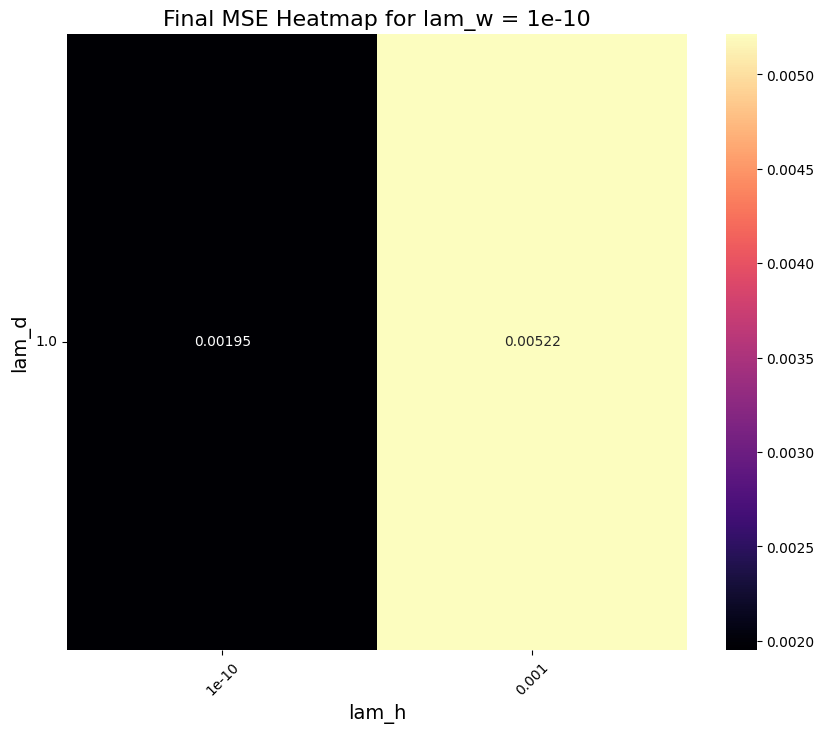

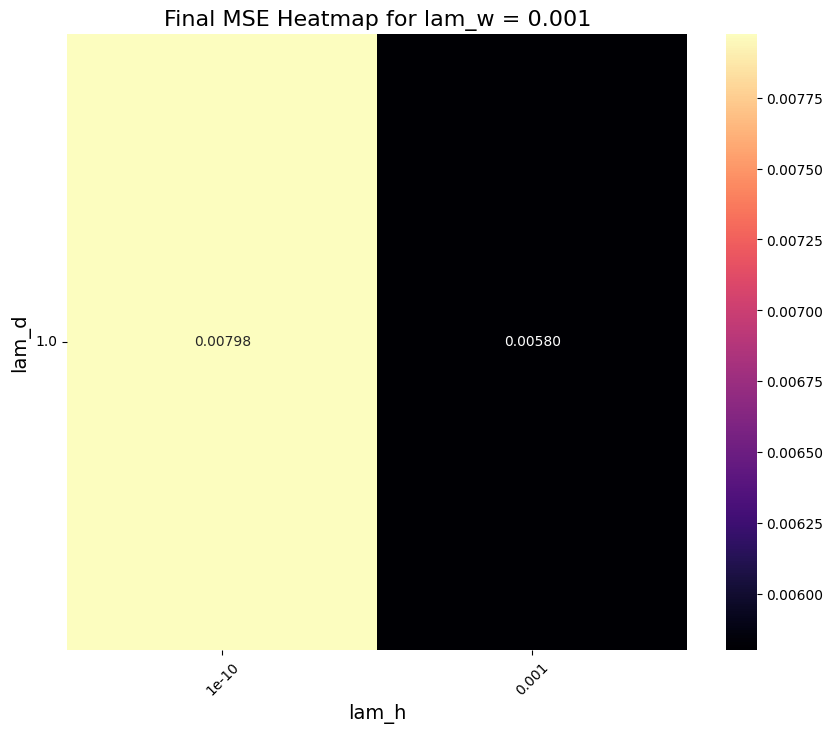

In [8]:
# Get unique values of lam_w
lam_w_values = sorted(results_df['lam_w'].unique())

for lam_w in lam_w_values:
    df_subset = results_df[results_df['lam_w'] == lam_w]
    pivot_table = df_subset.pivot(index='lam_d', columns='lam_h', values='final_mse')
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=True, fmt=".5f", cmap='magma')
    plt.title(f'Final MSE Heatmap for lam_w = {lam_w}', fontsize=16)
    plt.ylabel('lam_d', fontsize=14)
    plt.xlabel('lam_h', fontsize=14)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.show()


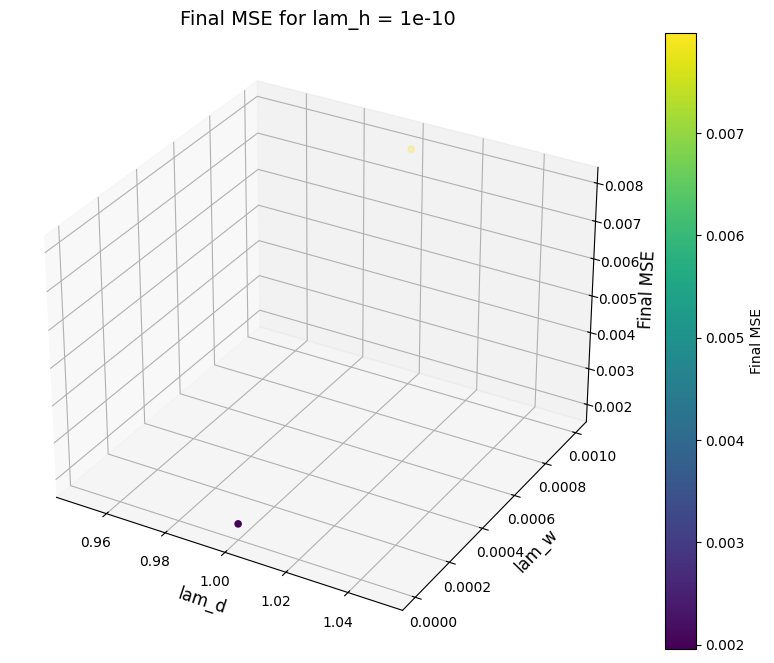

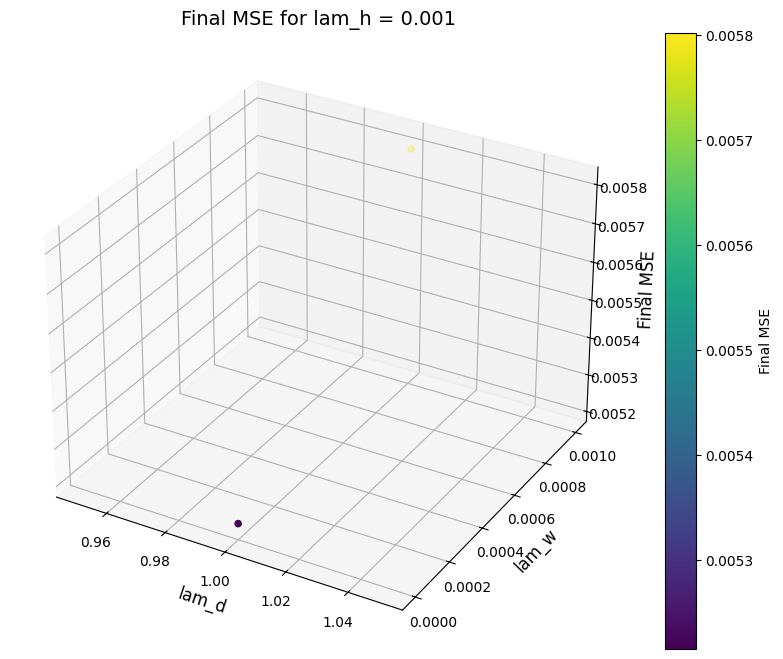

In [9]:
from mpl_toolkits.mplot3d import Axes3D

# For each lam_h value, create a 3D scatter plot
for lam_h in lam_h_values:
    df_subset = results_df[results_df['lam_h'] == lam_h]
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(
        df_subset['lam_d'],
        df_subset['lam_w'],
        df_subset['final_mse'],
        c=df_subset['final_mse'],
        cmap='viridis',
        depthshade=True
    )
    ax.set_xlabel('lam_d', fontsize=12)
    ax.set_ylabel('lam_w', fontsize=12)
    ax.set_zlabel('Final MSE', fontsize=12)
    ax.set_title(f'Final MSE for lam_h = {lam_h}', fontsize=14)
    fig.colorbar(sc, ax=ax, label='Final MSE')
    plt.show()


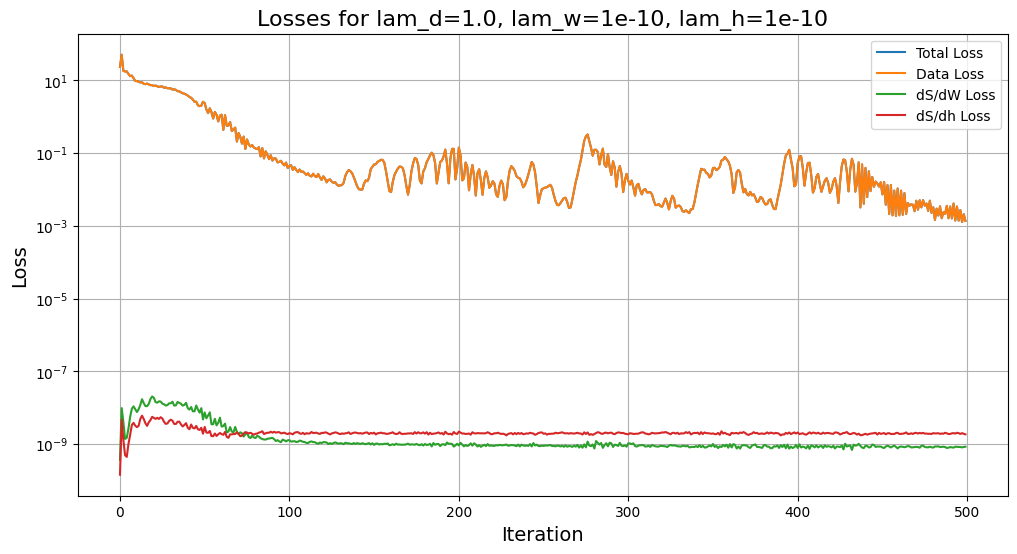

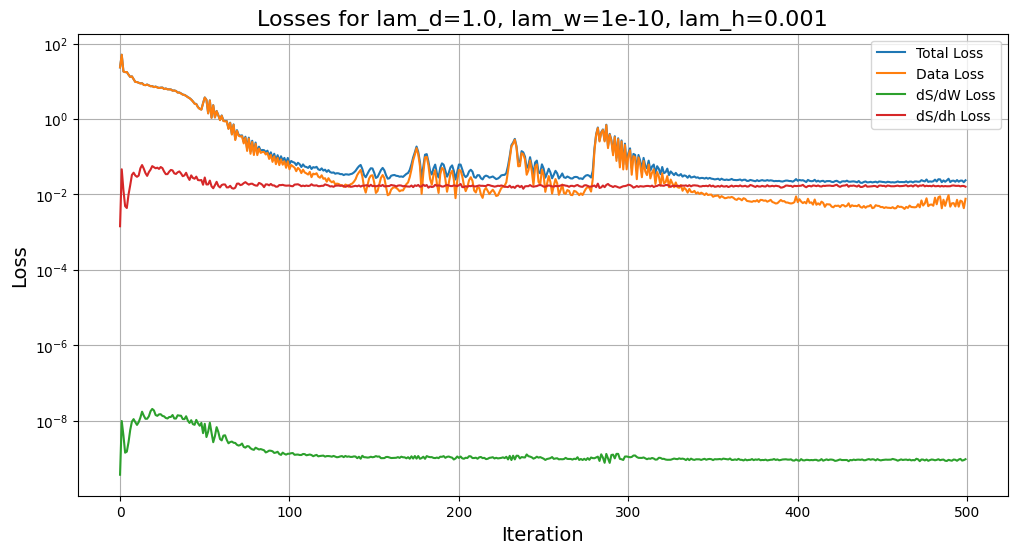

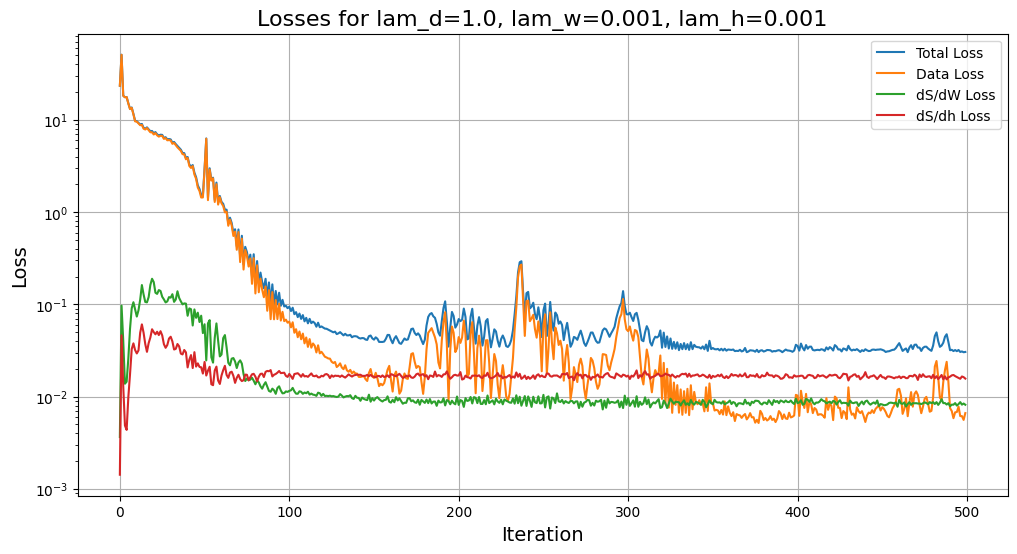

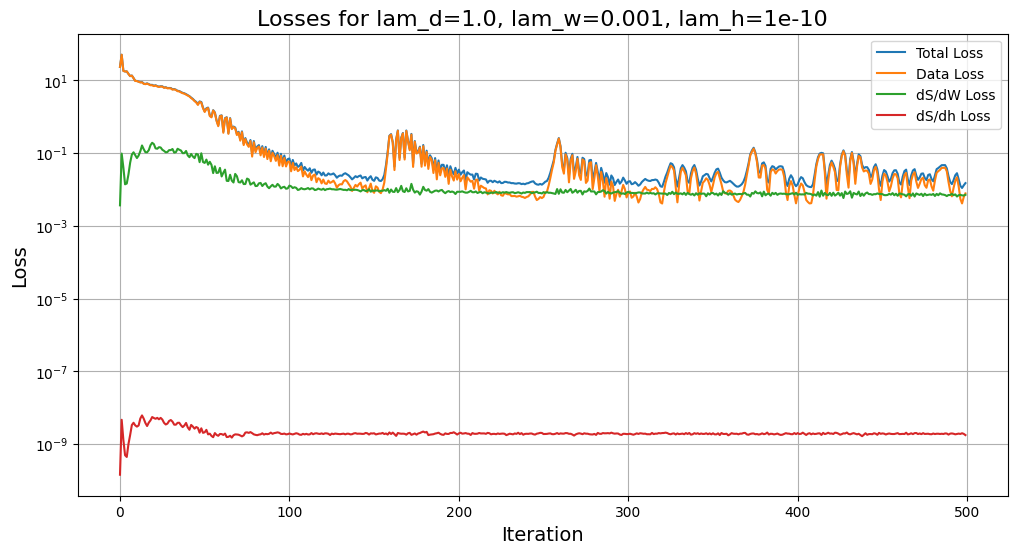

In [10]:
# Get the top 5 hyperparameter combinations with lowest final_mse
top_n = 5
top_results = results_df.nsmallest(top_n, 'final_mse').reset_index(drop=True)

for idx, row in top_results.iterrows():
    plt.figure(figsize=(12, 6))
    plt.plot(row['losses'], label='Total Loss')
    plt.plot(row['loss_d_list'], label='Data Loss')
    plt.plot(row['loss_sw_list'], label='dS/dW Loss')
    plt.plot(row['loss_sh_list'], label='dS/dh Loss')
    plt.yscale('log')
    plt.xlabel('Iteration', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title(f'Losses for lam_d={row["lam_d"]}, lam_w={row["lam_w"]}, lam_h={row["lam_h"]}', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()


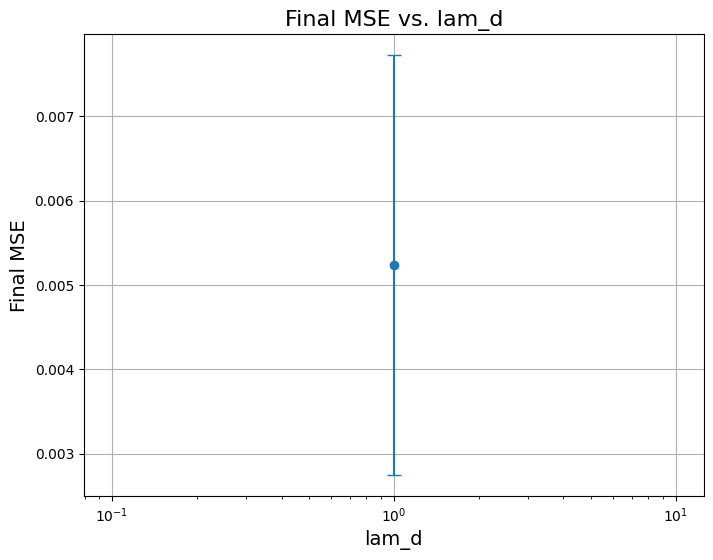

In [11]:
# Group by lam_d and compute mean and std of final_mse
grouped_lam_d = results_df.groupby('lam_d')['final_mse'].agg(['mean', 'std']).reset_index()

plt.figure(figsize=(8, 6))
plt.errorbar(
    grouped_lam_d['lam_d'],
    grouped_lam_d['mean'],
    yerr=grouped_lam_d['std'],
    fmt='o-',
    capsize=5
)
plt.xscale('log')
plt.xlabel('lam_d', fontsize=14)
plt.ylabel('Final MSE', fontsize=14)
plt.title('Final MSE vs. lam_d', fontsize=16)
plt.grid(True)
plt.show()


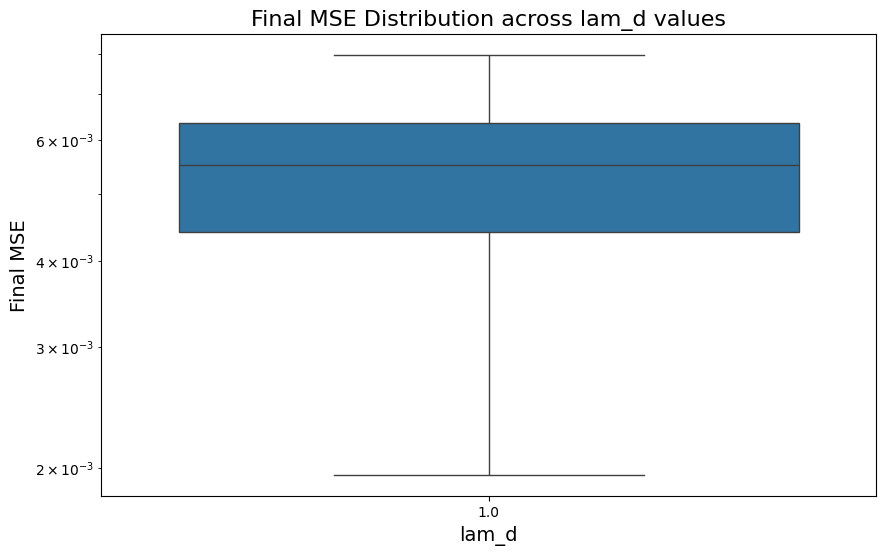

In [12]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='lam_d', y='final_mse', data=results_df)
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('lam_d', fontsize=14)
plt.ylabel('Final MSE', fontsize=14)
plt.title('Final MSE Distribution across lam_d values', fontsize=16)
plt.show()


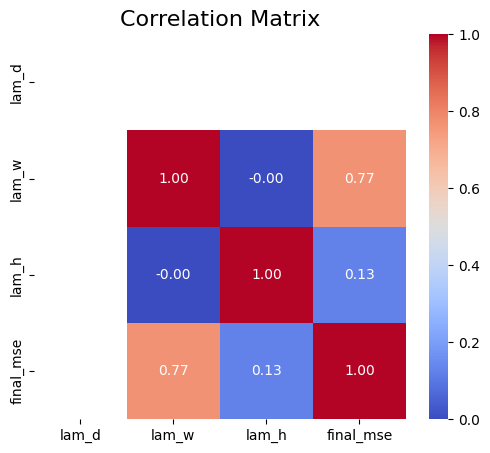

In [13]:
# Compute correlation matrix
corr_matrix = results_df[['lam_d', 'lam_w', 'lam_h', 'final_mse']].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix', fontsize=16)
plt.show()


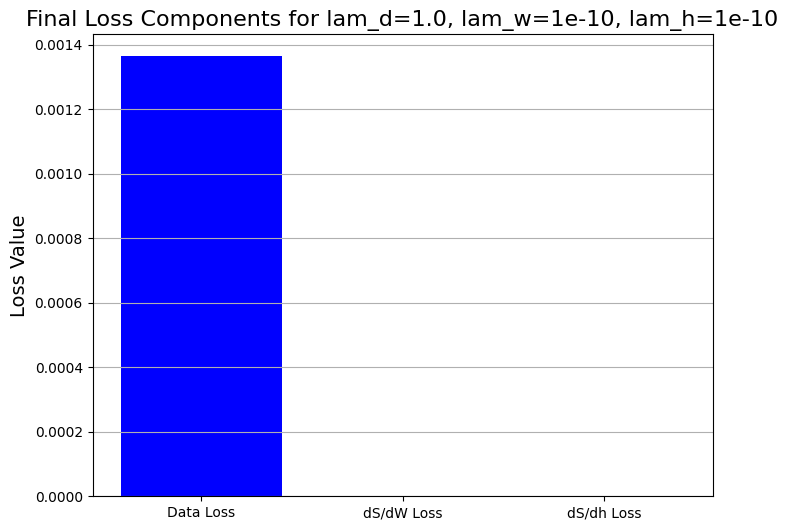

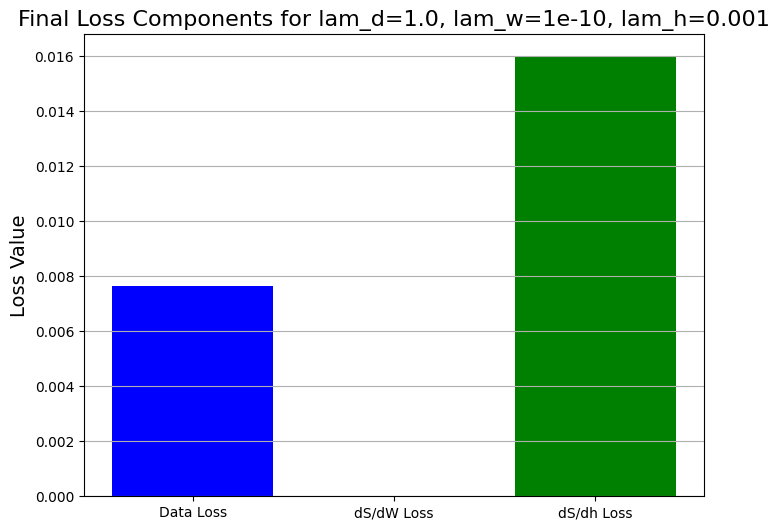

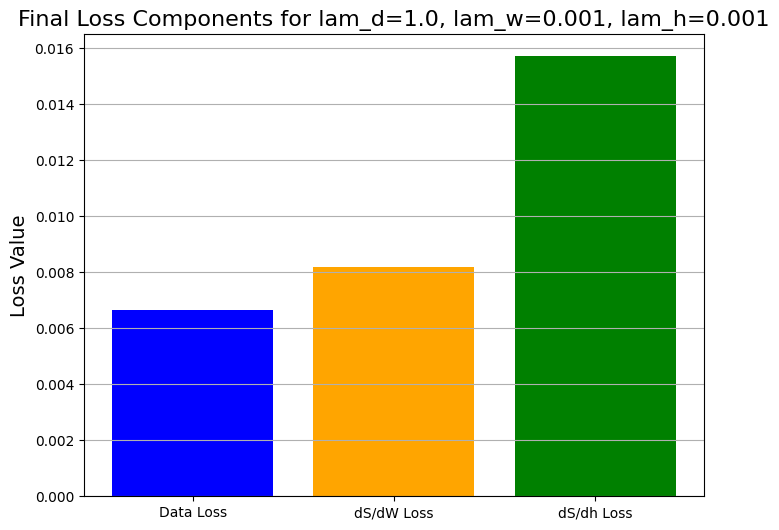

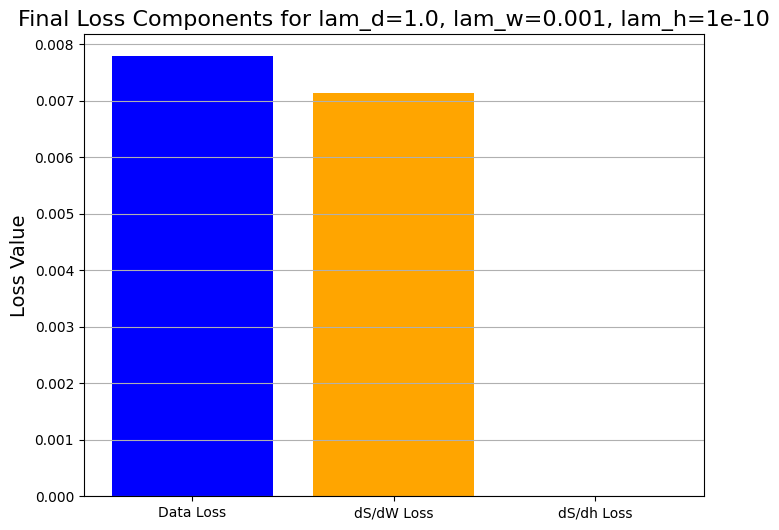

In [14]:
for idx, row in top_results.iterrows():
    final_loss_d = row['loss_d_list'][-1]
    final_loss_sw = row['loss_sw_list'][-1]
    final_loss_sh = row['loss_sh_list'][-1]
    components = ['Data Loss', 'dS/dW Loss', 'dS/dh Loss']
    values = [final_loss_d, final_loss_sw, final_loss_sh]
    
    plt.figure(figsize=(8, 6))
    plt.bar(components, values, color=['blue', 'orange', 'green'])
    plt.title(f'Final Loss Components for lam_d={row["lam_d"]}, lam_w={row["lam_w"]}, lam_h={row["lam_h"]}', fontsize=16)
    plt.ylabel('Loss Value', fontsize=14)
    plt.grid(axis='y')
    plt.show()


In [15]:
mean_mse = results_df['final_mse'].mean()
std_mse = results_df['final_mse'].std()
min_mse = results_df['final_mse'].min()
max_mse = results_df['final_mse'].max()

print(f'Mean Final MSE: {mean_mse:.5f}')
print(f'Std of Final MSE: {std_mse:.5f}')
print(f'Min Final MSE: {min_mse:.5f}')
print(f'Max Final MSE: {max_mse:.5f}')


Mean Final MSE: 0.00524
Std of Final MSE: 0.00249
Min Final MSE: 0.00195
Max Final MSE: 0.00798


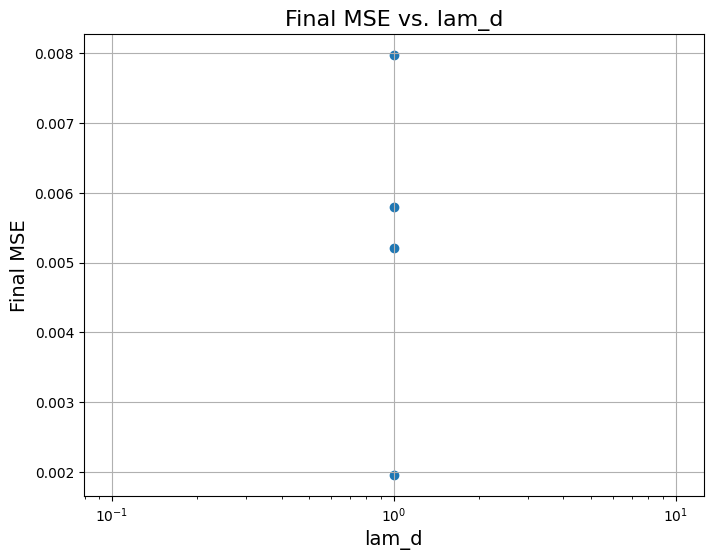

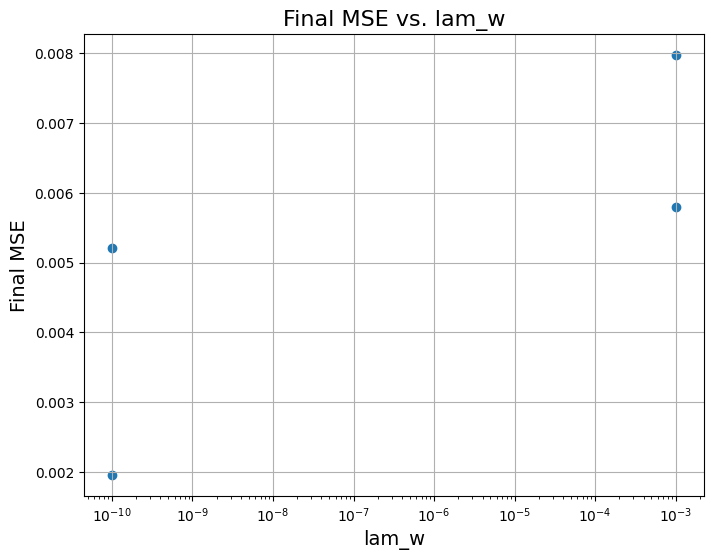

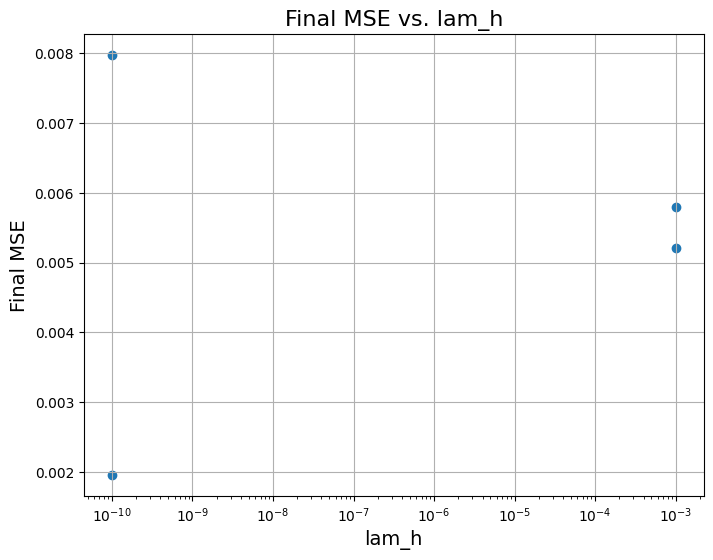

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(results_df['lam_d'], results_df['final_mse'])
plt.xscale('log')
plt.xlabel('lam_d', fontsize=14)
plt.ylabel('Final MSE', fontsize=14)
plt.title('Final MSE vs. lam_d', fontsize=16)
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(results_df['lam_w'], results_df['final_mse'])
plt.xscale('log')
plt.xlabel('lam_w', fontsize=14)
plt.ylabel('Final MSE', fontsize=14)
plt.title('Final MSE vs. lam_w', fontsize=16)
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(results_df['lam_h'], results_df['final_mse'])
plt.xscale('log')
plt.xlabel('lam_h', fontsize=14)
plt.ylabel('Final MSE', fontsize=14)
plt.title('Final MSE vs. lam_h', fontsize=16)
plt.grid(True)
plt.show()


In [17]:
# Display top 10 hyperparameter combinations with lowest final_mse
top_10 = results_df.nsmallest(10, 'final_mse').reset_index(drop=True)
print(top_10[['lam_d', 'lam_w', 'lam_h', 'final_mse']])


   lam_d         lam_w         lam_h  final_mse
0    1.0  1.000000e-10  1.000000e-10   0.001954
1    1.0  1.000000e-10  1.000000e-03   0.005216
2    1.0  1.000000e-03  1.000000e-03   0.005802
3    1.0  1.000000e-03  1.000000e-10   0.007977


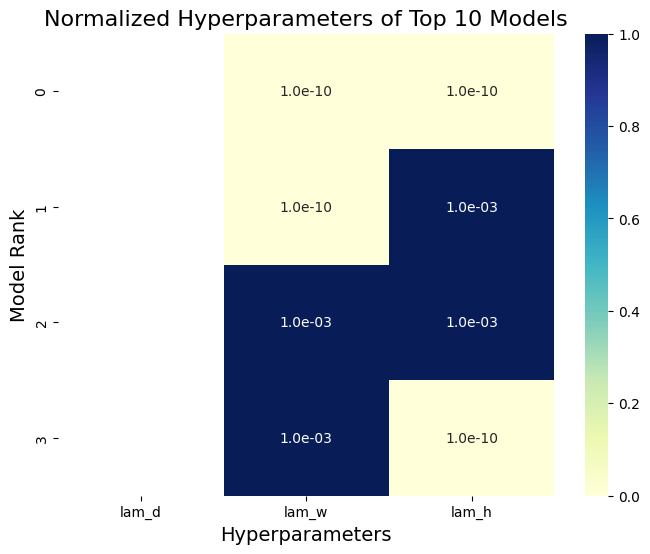

In [18]:
# Create a DataFrame of hyperparameters for top models
top_hyperparams = top_10[['lam_d', 'lam_w', 'lam_h']]

# Normalize hyperparameter values for heatmap
top_hyperparams_norm = (top_hyperparams - top_hyperparams.min()) / (top_hyperparams.max() - top_hyperparams.min())

plt.figure(figsize=(8, 6))
sns.heatmap(top_hyperparams_norm, annot=top_hyperparams, fmt=".1e", cmap='YlGnBu')
plt.title('Normalized Hyperparameters of Top 10 Models', fontsize=16)
plt.xlabel('Hyperparameters', fontsize=14)
plt.ylabel('Model Rank', fontsize=14)
plt.show()


In [19]:
# Save results_df to a CSV file
results_df.to_csv('hyperparameter_search_results.csv', index=False)


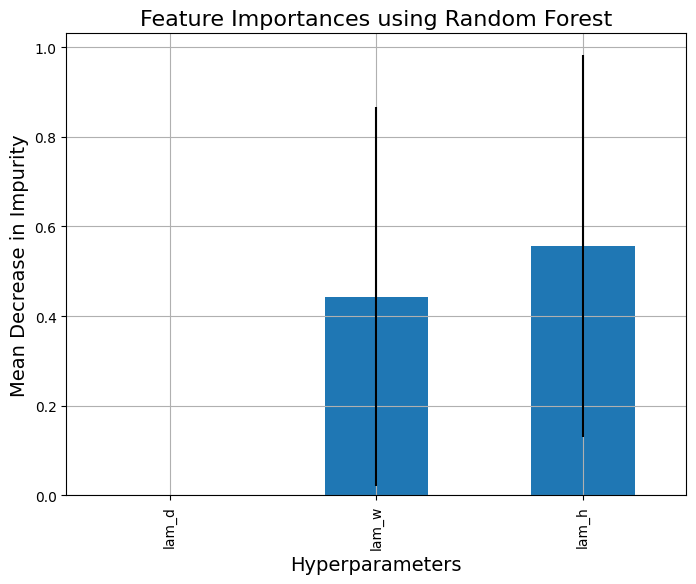

In [20]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

# Prepare data
X = results_df[['lam_d', 'lam_w', 'lam_h']]
y = results_df['final_mse']

# Fit a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Compute feature importances
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
feature_names = ['lam_d', 'lam_w', 'lam_h']

# Plot feature importances
forest_importances = pd.Series(importances, index=feature_names)

plt.figure(figsize=(8, 6))
forest_importances.plot.bar(yerr=std)
plt.title('Feature Importances using Random Forest', fontsize=16)
plt.ylabel('Mean Decrease in Impurity', fontsize=14)
plt.xlabel('Hyperparameters', fontsize=14)
plt.grid(True)
plt.show()


## Dev space

### Curriculum Learning Approach

100%|██████████| 20000/20000 [11:22<00:00, 29.32it/s, Total Loss=0.00332, LR=1e-6, Data Loss=0.00053, dS/dW Loss=0.000505, dS/dh Loss=0.00229]    


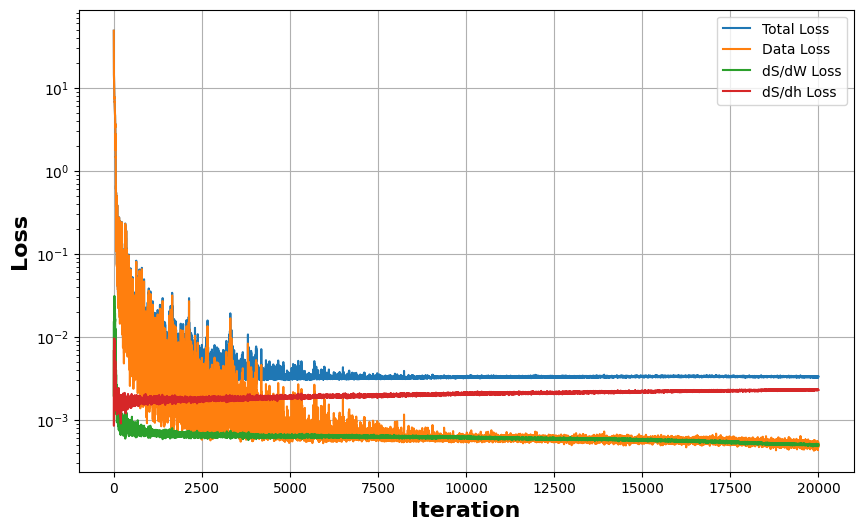

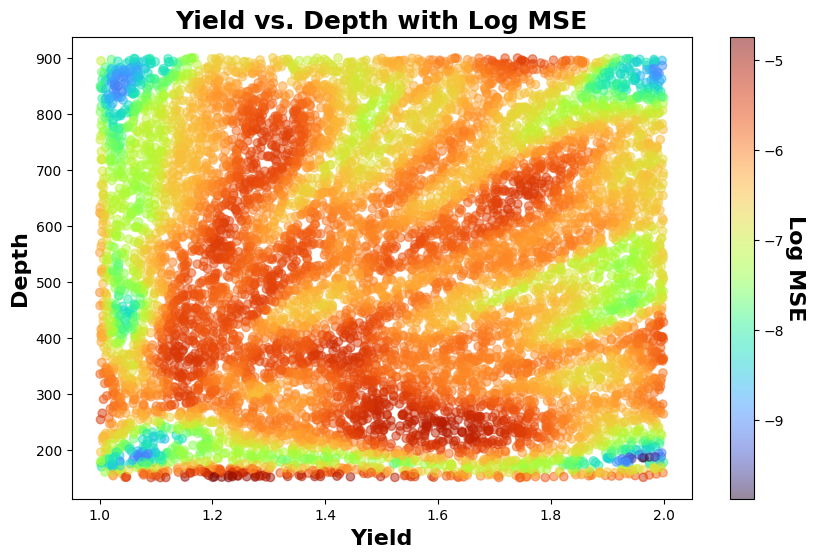

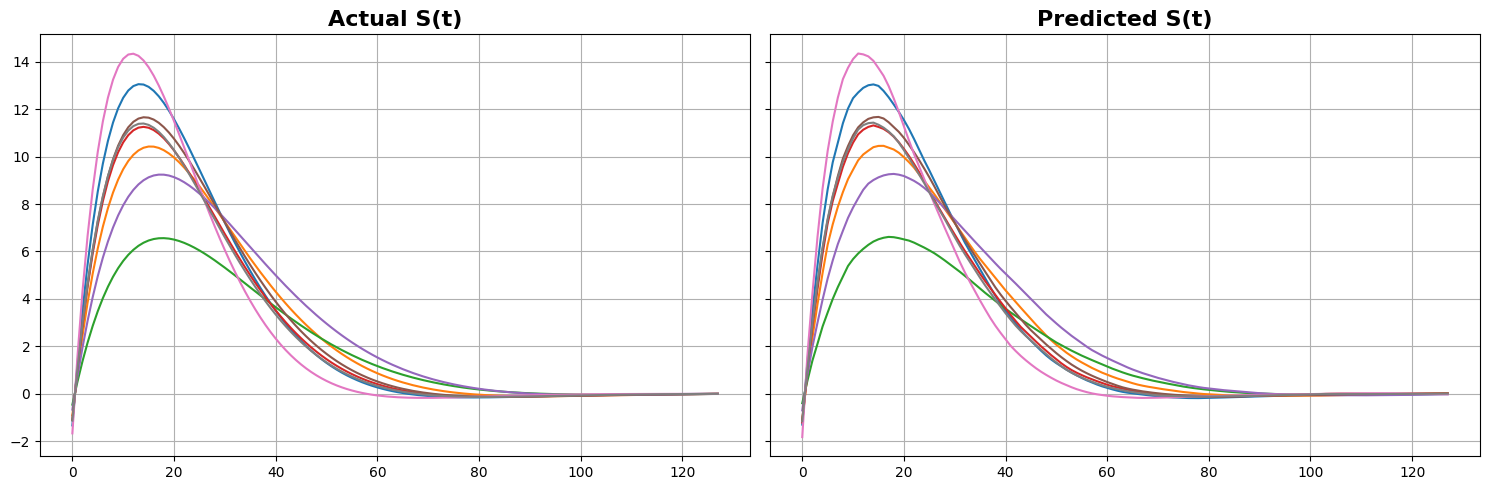

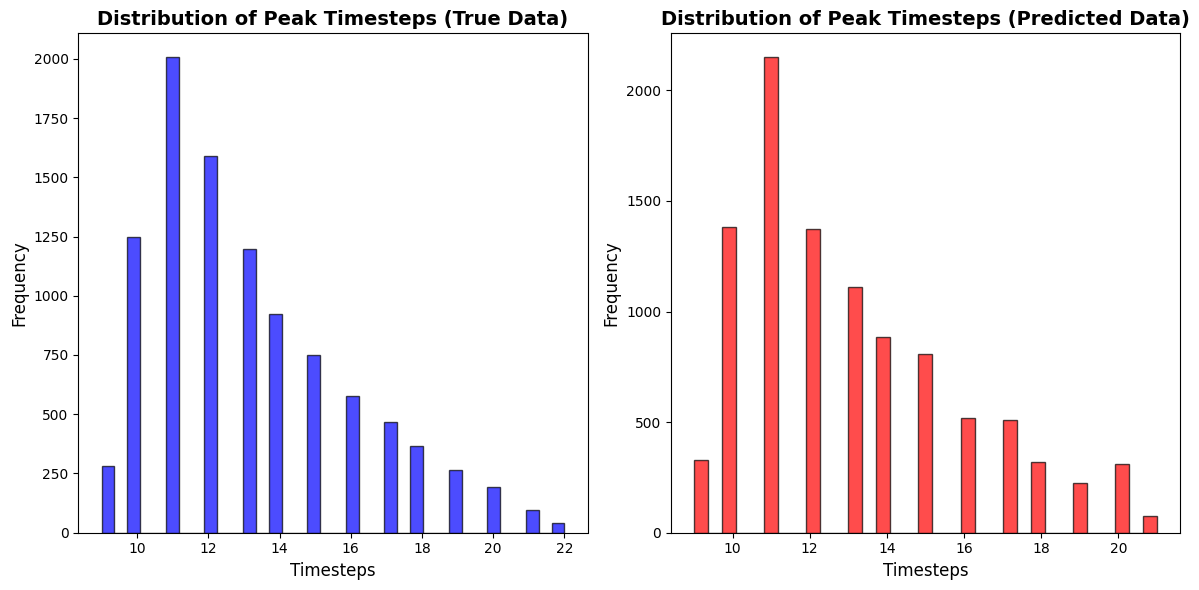

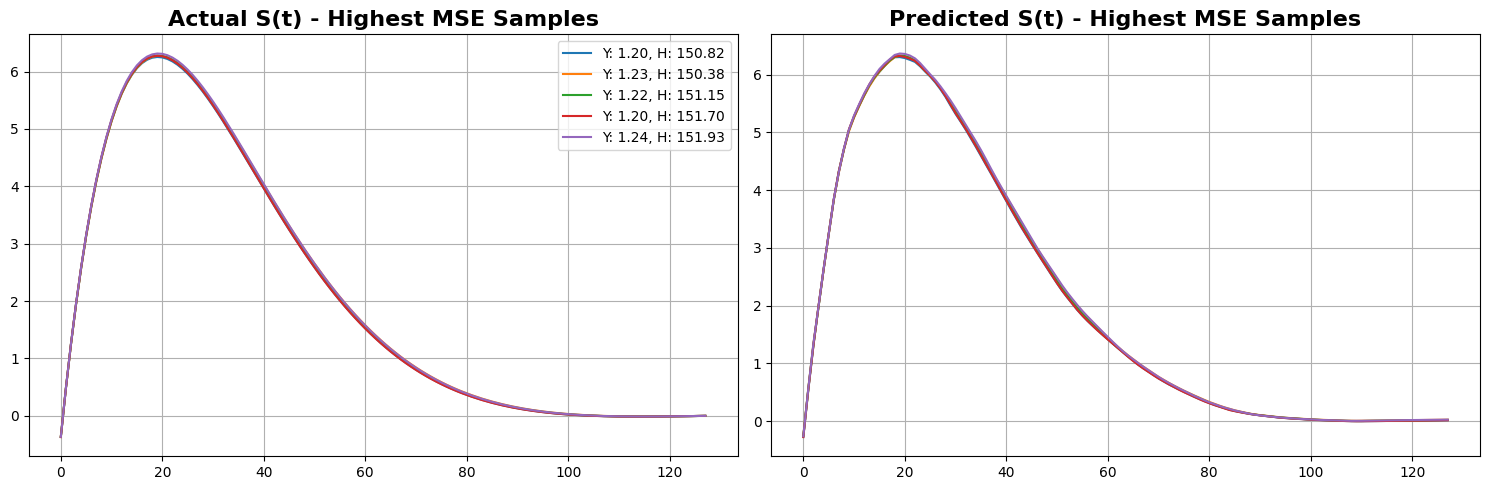

In [ ]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax
from optax import tree_utils as otu
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

# Update JAX configuration
jax.config.update("jax_enable_x64", False)

# Set the random seed
base_seed = 42
key = jax.random.PRNGKey(base_seed)
np.random.seed(base_seed)

# Define the dictionary with constants for each material
constants_dict = {
    "Tuff/Rhyolite": {
        "h0": 122.0, "R0": 202.0, "gamma0": 26.0, "P10": 3.6e6, "P20": 5.0e6,
        "pv": 3500.0, "sv": 2021.0, "n": 2.4, "rho": 2000.0
    },
    "Granite": {
        "h0": 122.0, "R0": 321.0, "gamma0": 34.0, "P10": 4.6e6, "P20": 2.4e6,
        "pv": 5500.0, "sv": 3175.0, "n": 2.4, "rho": 2550.0
    }
}

# Function to retrieve constants for a material
def get_constants(material_name):
    if material_name in constants_dict:
        material_constants = constants_dict[material_name]
        # Convert constants to JAX arrays with dtype float32
        return {key: jnp.array(value, dtype=jnp.float32) for key, value in material_constants.items()}
    else:
        raise ValueError(f"Material '{material_name}' not found in the constants dictionary.")

# Set the material and get constants
material = 'Tuff/Rhyolite'
constants = get_constants(material)

# Define the Neural Network class using Flax
class NeuralNet(nn.Module):
    input_dimension: int
    output_dimension: int
    n_hidden_layers: int
    neurons: int
    activation: callable
    regularization_param: float
    regularization_exp: float

    def setup(self):
        # Use LeCun uniform initializer for tanh activation
        kernel_init = nn.initializers.lecun_uniform()
        bias_init = nn.initializers.zeros

        # Layers
        self.input_layer = nn.Dense(
            self.neurons, kernel_init=kernel_init, bias_init=bias_init)
        self.hidden_layers = [
            nn.Dense(self.neurons, kernel_init=kernel_init, bias_init=bias_init)
            for _ in range(self.n_hidden_layers - 1)
        ]
        self.output_layer = nn.Dense(
            self.output_dimension, kernel_init=kernel_init, bias_init=bias_init)

    def __call__(self, x):
        x = self.activation(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        return self.output_layer(x)

    def l2_regularization(self):
        params = self.get_variable('params', 'kernel')
        reg_loss = 0.0
        for param in jax.tree_leaves(params):
            reg_loss += jnp.sum(jnp.abs(param) ** self.regularization_exp)
        return self.regularization_param * reg_loss

# Create the compute_stf_batch function with constants embedded
def make_compute_stf_batch(constants):
    h0 = constants['h0']
    R0 = constants['R0']
    gamma0 = constants['gamma0']
    P10 = constants['P10']
    P20 = constants['P20']
    pv = constants['pv']
    sv = constants['sv']
    n = constants['n']
    rho = constants['rho']

    @jax.jit
    def compute_stf_batch(w, h, t):
        mu = rho * sv ** 2
        lam = rho * pv ** 2 - 2 * mu

        # Compute R_el, gamma, beta, etc.
        h_ratio = h0 / h
        w_power = w ** (1 / 3)
        R_el = R0 * h_ratio ** (1 / n) * w_power
        gamma = gamma0 * (R0 / R_el)
        beta = (lam + 2 * mu) / (4 * mu)
        w0 = pv / R_el
        alpha = w0 / (2 * beta)
        sqrt_term = jnp.sqrt(1 / (2 * beta) - 1 / (4 * beta ** 2))
        p = w0 * sqrt_term

        exp_alpha_t = jnp.exp(-alpha * t)
        sin_p_t = jnp.sin(p * t)
        cos_p_t = jnp.cos(p * t)
        exp_gamma_t = jnp.exp(-gamma * t)
        H_t = jnp.where(t >= 0, 1.0, 0.0)

        # Compute f(t) and its derivative df/dt
        pv_squared = pv ** 2
        beta_p = beta * p
        f_prefactor = (R_el / (4 * alpha)) * (pv_squared / beta_p)
        f_t_val = f_prefactor * exp_alpha_t * sin_p_t * H_t

        A = (R_el / (4 * mu)) * (pv_squared / beta_p)
        df_dt = A * exp_alpha_t * (-alpha * sin_p_t + p * cos_p_t) * H_t

        # Compute B(t)
        P0_t = P10 * (h / h0)
        h_ratio_third = h_ratio ** (1 / 3)
        R_ratio_cubed = (R0 / R_el) ** 3
        P2_t = P20 * h_ratio_third * R_ratio_cubed * w ** 0.87
        B_t_val = (exp_gamma_t * P0_t + P2_t) * H_t

        df_dt_div = -df_dt / (R_el * pv)

        # Convolution
        S_t = jax.vmap(lambda a, b: jnp.convolve(a, b, mode='full'))(df_dt_div, B_t_val)
        S_t = S_t[:, t.shape[1] - 1: t.shape[1] * 2 - 1]

        # Analytical derivatives
        gamma_over_Rel = gamma / R_el
        n_over_Rel = n / R_el
        term1 = -exp_gamma_t * P10 * (h / h0) * (
            t * gamma_over_Rel - n_over_Rel * h_ratio ** (1 / n)
        ) * (h * w ** (-1 / 3)) ** (1 / 3)
        term3 = (1 - exp_gamma_t) * (
            (1 / 3) * n * R0 ** 2 / R_el ** 3 * h_ratio_third * w ** (-2 / 3) * (h * w ** (-1 / 3)) ** (1 / 3)
        )
        term4 = (1 - exp_gamma_t) * (
            -3 * R0 ** 3 / R_el ** 4 * h_ratio_third * (h * w ** (-1 / 3)) ** (1 / 3)
        )
        dB_t_dRel = (term1 + term3 + term4) * H_t

        dS_t_dRel = jax.vmap(lambda a, b: jnp.convolve(a, b, mode='full'))(df_dt_div, dB_t_dRel)
        dS_t_dRel = dS_t_dRel[:, t.shape[1] - 1: t.shape[1] * 2 - 1]

        # Derivatives of R_el
        dRel_dw = R_el / (3 * w)
        dRel_dh = -R_el / (n * h)

        dS_dW_ana = dS_t_dRel * dRel_dw
        dS_dh_ana = dS_t_dRel * dRel_dh

        return S_t, dS_dW_ana, dS_dh_ana

    return compute_stf_batch

# Create the compute_stf_batch function with constants embedded
compute_stf_batch = make_compute_stf_batch(constants)

def sample_edges(key, size, min_val, max_val, edge_low, edge_high1, edge_high2):
    key, subkey = jax.random.split(key)
    # Sample from edges uniformly
    edge_values = jnp.concatenate([
        jax.random.uniform(subkey, shape=(size // 2,), minval=min_val, maxval=edge_high1),
        jax.random.uniform(subkey, shape=(size - size // 2,), minval=edge_high2 - (edge_high1 - min_val), maxval=max_val)
    ])
    return key, edge_values

def sample_center(key, size, min_val, max_val, center_low, center_high):
    key, subkey = jax.random.split(key)
    center_values = jax.random.uniform(subkey, shape=(size,), minval=center_low, maxval=center_high)
    return key, center_values


def sample_progressive(key, size, min_val, max_val, edge_low, edge_high1, edge_high2, center_low, center_high, progress):
    # Compute probabilities
    edge_prob = max(1.0 - progress, 0.0)
    center_prob = min(progress, 1.0)
    
    # Determine the number of samples from edges and center
    n_edge = int(size * edge_prob)
    n_center = size - n_edge
    
    # Sample from edges
    key, edge_values = sample_edges(key, n_edge, min_val, max_val, edge_low, edge_high1, edge_high2)
    
    # Sample from center
    key, center_values = sample_center(key, n_center, min_val, max_val, center_low, center_high)
    
    # Combine samples
    values = jnp.concatenate([edge_values, center_values])
    
    # Shuffle values to avoid ordering effects
    key, subkey = jax.random.split(key)
    permuted_indices = jax.random.permutation(subkey, size)
    values = values[permuted_indices]
    
    return key, values

# Define domain boundaries
hmin, hmax = 150.0, 900.0
wmin, wmax = 1.0, 2.0

# Define edge percentage (e.g., 25% from each side)
edge_percentage = 0.1

# Compute thresholds for h (depth)
h_edge_low = hmin
h_edge_high = hmin + edge_percentage * (hmax - hmin)
h_center_low = h_edge_high
h_center_high = hmax - edge_percentage * (hmax - hmin)
h_edge_high2 = hmax

# Similarly for w (yield)
w_edge_low = wmin
w_edge_high = wmin + edge_percentage * (wmax - wmin)
w_center_low = w_edge_high
w_center_high = wmax - edge_percentage * (wmax - wmin)
w_edge_high2 = wmax


# Generate batch function without passing 'material'
def generate_batch(key, b, nt, tmin, tmax, progress):
    # Sample h (depth)
    key, h_values = sample_progressive(
        key, b, hmin, hmax, h_edge_low, h_edge_high, h_edge_high2, h_center_low, h_center_high, progress
    )
    h = h_values.reshape(-1, 1)
    
    # Sample w (yield)
    key, w_values = sample_progressive(
        key, b, wmin, wmax, w_edge_low, w_edge_high, w_edge_high2, w_center_low, w_center_high, progress
    )
    w = w_values.reshape(-1, 1)
    
    # Sample t (time)
    t = jnp.linspace(tmin, tmax, nt)
    t = jnp.tile(t, (b, 1))  # Shape (b, nt)
    t = jnp.linspace(tmin, tmax, nt)
    t = jnp.tile(t, (b, 1))  # Shape (b, nt)

    # Compute STF and derivatives
    S_t, dS_dW, dS_dh = compute_stf_batch(w, h, t)

    hnorm = (h / hmax).squeeze()        # Shape (b,)
    wnorm = (w / wmax).squeeze()        # Shape (b,)
    tnorm = t / tmax                    # Shape (b, nt)
    tnorm_flat = tnorm.flatten()        # Shape (b * nt,)

    # Prepare input x
    x = jnp.stack((
        tnorm_flat,                    # Shape (b * nt,)
        jnp.repeat(wnorm, nt),         # Shape (b * nt,)
        jnp.repeat(hnorm, nt)          # Shape (b * nt,)
    ), axis=-1)

    # Compute smax and smin
    smax = jnp.max(S_t, axis=1, keepdims=True)  # Shape (b, 1)
    smin = jnp.min(S_t, axis=1, keepdims=True)  # Shape (b, 1)

    # Repeat smax and smin along the time axis to match (b, nt)
    smax = jnp.tile(smax, (1, nt)).flatten()    # Shape (b * nt,)
    smin = jnp.tile(smin, (1, nt)).flatten()    # Shape (b * nt,)

    # Flatten S_t and derivatives
    S_t_flat = S_t.flatten()         # Shape (b * nt,)
    dS_dW_flat = dS_dW.flatten()     # Shape (b * nt,)
    dS_dh_flat = dS_dh.flatten()     # Shape (b * nt,)

    # Compute per-sample xmax and xmin
    xmax = jnp.max(x, axis=0, keepdims=True)  # Shape (1, 3)
    xmin = jnp.min(x, axis=0, keepdims=True)  # Shape (1, 3)

    # Prepare batch data
    batch = (
        x,                 # Shape (b * nt, 3)
        S_t_flat,          # Shape (b * nt,)
        smax,              # Shape (b * nt,)
        smin,              # Shape (b * nt,)
        xmax,              # Shape (1, 3)
        xmin,              # Shape (1, 3)
        dS_dW_flat,        # Shape (b * nt,)
        dS_dh_flat         # Shape (b * nt,)
    )

    return key, batch

# Training parameters
b = 512
nt = 128
tmax = 0.5
tmin = 0.0
n_iter = 20000

lam_w = 1e-4
lam_h = 1e-4
lam_d = 1e-0

# Create the model
model = NeuralNet(
    input_dimension=3,
    output_dimension=1,
    n_hidden_layers=6,
    neurons=256,
    activation=nn.relu,
    regularization_param=0.5,
    regularization_exp=2.0,
)

# Initialize model parameters
key, subkey = jax.random.split(key)
dummy_input = jnp.ones((1, 3), dtype=jnp.float32)
params = model.init(subkey, dummy_input)

# Define optimizer and scheduler
initial_learning_rate = 1e-3

optimizer = optax.chain(
    optax.adam(initial_learning_rate),
        optax.contrib.reduce_on_plateau(
        patience=100,
        cooldown=100,
        factor=0.90,
        rtol=0.0001,
        accumulation_size=1,
        min_scale = 1e-3,
    ),
)
opt_state = optimizer.init(params)

# Define the loss function
def loss_fn(params, batch):
    x, S_t, smax, smin, xmax, xmin, dS_dW, dS_dh = batch
    # Forward pass
    s = model.apply(params, (x - xmin) / (xmax - xmin))
    s = s.squeeze() * (smax - smin) + smin



    # Data loss
    loss_d = lam_d * jnp.mean((s - S_t) ** 2)

    # Compute gradients w.r.t x
    def s_fn(x_i, smax_i, smin_i):
        x_i_norm = (x_i - xmin) / (xmax - xmin)
        s_i = model.apply(params, x_i_norm).squeeze() * (smax_i - smin_i) + smin_i
        return s_i

    # Vectorize gradient computation over all samples
    grad_s_x = jax.vmap(
        jax.grad(s_fn, argnums=0),
        in_axes=(0, 0, 0)
    )(x, smax, smin)

    # Extract gradients w.r.t wnorm and hnorm (x[:,1], x[:,2])
    grad_s_w = grad_s_x[:, 1]  # Gradient w.r.t wnorm
    grad_s_h = grad_s_x[:, 2]  # Gradient w.r.t hnorm

    # Derivative losses
    loss_sw = lam_w * jnp.mean((grad_s_w - dS_dW) ** 2)
    loss_sh = lam_h * jnp.mean((grad_s_h - dS_dh) ** 2)

    # Total loss
    total_loss = loss_d + loss_sw + loss_sh
    return total_loss, (loss_d, loss_sw, loss_sh)

@jax.jit
def train_step(params, opt_state, batch, step):
    (loss, losses), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, batch)
    updates, opt_state = optimizer.update(grads, opt_state, params, step=step, value=loss)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss, losses

# Pre-compile the train_step function
key, batch = generate_batch(key, b, nt, tmin, tmax, progress)
params, opt_state, _, _ = train_step(params, opt_state, batch, 0)

# Training loop with progress bar
losses = []
loss_d_list = []
loss_sw_list = []
loss_sh_list = []
learning_rates = []

pbar = trange(n_iter)
for step in pbar:
    # Compute progress (from 0.0 to 1.0)
    progress = 1 - step / n_iter
    
    # Generate batch data with progressive sampling
    key, batch = generate_batch(key, b, nt, tmin, tmax, progress)
    
    # Perform a training step
    params, opt_state, loss, (loss_d, loss_sw, loss_sh) = train_step(params, opt_state, batch, step)

    # Update loss lists
    losses.append(float(loss))
    loss_d_list.append(float(loss_d))
    loss_sw_list.append(float(loss_sw))
    loss_sh_list.append(float(loss_sh))

    # Get the current learning rate from the scheduler
    lr_scale = otu.tree_get(opt_state, "scale")
    current_lr = lr_scale * initial_learning_rate
    learning_rates.append(float(current_lr))

    # Update progress bar
    pbar.set_postfix({
        'Total Loss': float(loss),
        'LR': float(current_lr),
        'Data Loss': float(loss_d),
        'dS/dW Loss': float(loss_sw),
        'dS/dh Loss': float(loss_sh)
    })

# Plot losses
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(losses, label='Total Loss')
plt.plot(loss_d_list, label='Data Loss')
plt.plot(loss_sw_list, label='dS/dW Loss')
plt.plot(loss_sh_list, label='dS/dh Loss')
plt.yscale('log')
plt.xlabel('Iteration', fontsize=16, fontweight='bold')
plt.ylabel('Loss', fontsize=16, fontweight='bold')
plt.legend()
plt.show()


# Evaluate the model
b = 10000  # Batch size for evaluation

# Generate new h, w, t values for evaluation
key, subkey = jax.random.split(key)
h = jax.random.uniform(subkey, shape=(b, 1), minval=hmin, maxval=hmax)
key, subkey = jax.random.split(key)
w = jax.random.uniform(subkey, shape=(b, 1), minval=wmin, maxval=wmax)
t = jnp.linspace(tmin, tmax, nt)
t = jnp.tile(t, (b, 1))  # Shape (b, nt)

# Compute true S_t and analytical derivatives
S_t, dS_dW_ana, dS_dh_ana = compute_stf_batch(w, h, t)

# Normalize h, w, t
hnorm = (h / hmax).squeeze()  # Shape (b,)
wnorm = (w / wmax).squeeze()  # Shape (b,)
tnorm = t / tmax              # Shape (b, nt)

# Flatten tnorm
tnorm_flat = tnorm.flatten()  # Shape (b * nt,)

# Repeat hnorm and wnorm to match the time dimension
hnorm_flat = jnp.repeat(hnorm, nt)  # Shape (b * nt,)
wnorm_flat = jnp.repeat(wnorm, nt)  # Shape (b * nt,)

# Prepare input x by stacking tnorm_flat, wnorm_flat, and hnorm_flat
x = jnp.stack((tnorm_flat, wnorm_flat, hnorm_flat), axis=-1)  # Shape (b * nt, 3)

# Compute xmax and xmin over all data (consistent with training)
xmax = jnp.max(x, axis=0, keepdims=True)  # Shape (1, 3)
xmin = jnp.min(x, axis=0, keepdims=True)  # Shape (1, 3)

# Normalize x
x_normalized = (x - xmin) / (xmax - xmin)  # Shape (b * nt, 3)

# Compute smax and smin per sample
smax = jnp.max(S_t, axis=1, keepdims=True)  # Shape (b, 1)
smin = jnp.min(S_t, axis=1, keepdims=True)  # Shape (b, 1)

# Repeat smax and smin along the time dimension to match (b, nt)
smax = jnp.tile(smax, (1, nt)).flatten()  # Shape (b * nt,)
smin = jnp.tile(smin, (1, nt)).flatten()  # Shape (b * nt,)

# Evaluate the model
s_pred = model.apply(params, x_normalized)  # Shape (b * nt, 1)
s_pred = s_pred.squeeze()  # Shape (b * nt,)

# Apply inverse normalization to s_pred
s_pred = s_pred * (smax - smin) + smin  # Shape (b * nt,)

# Reshape s_pred and S_t to (b, nt) for comparison
s_pred = s_pred.reshape(b, nt)  # Shape (b, nt)
S_t = S_t.reshape(b, nt)        # Shape (b, nt)

# Compute MSE over time steps for each sample
mse = jnp.mean((S_t - s_pred) ** 2, axis=1)  # Shape (b,)

# Convert JAX arrays to NumPy arrays for plotting
w_np = np.array(w.squeeze())
h_np = np.array(h.squeeze())
mse_np = np.array(mse)
S_t_np = np.array(S_t)
s_pred_np = np.array(s_pred)

# Plot yield vs depth with MSE
fig = plt.figure(figsize=(10, 6))
plt.scatter(
    x=w_np,  # Yield values
    y=h_np,  # Depth values
    c=np.log(mse_np),  # Log of MSE for color mapping
    cmap='turbo',
    alpha=0.5
)
cbar = plt.colorbar()
cbar.set_label('Log MSE', rotation=270, fontsize=16, fontweight='bold')
cbar.ax.get_yaxis().labelpad = 15
plt.xlabel('Yield', fontsize=16, fontweight='bold')
plt.ylabel('Depth', fontsize=16, fontweight='bold')
plt.title('Yield vs. Depth with Log MSE', fontsize=18, fontweight='bold')
plt.show()

# Plot actual and predicted S(t)
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
for ax in axs:
    ax.grid(True)

axs[0].set_title('Actual S(t)', fontsize=16, fontweight='bold')
axs[1].set_title('Predicted S(t)', fontsize=16, fontweight='bold')

for i in range(8):
    axs[0].plot(S_t_np[i], alpha=1.)
    axs[1].plot(s_pred_np[i], alpha=1.)

plt.tight_layout()
plt.show()

# Find peaks for true and predicted data
true_peaks = np.argmax(S_t_np, axis=1)      # Shape (b,)
predicted_peaks = np.argmax(s_pred_np, axis=1)   # Shape (b,)

# Plot the distribution of peaks
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(true_peaks, bins='auto', color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Peak Timesteps (True Data)', fontsize=14, fontweight='bold')
plt.xlabel('Timesteps', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(1, 2, 2)
plt.hist(predicted_peaks, bins='auto', color='red', alpha=0.7, edgecolor='black')
plt.title('Distribution of Peak Timesteps (Predicted Data)', fontsize=14, fontweight='bold')
plt.xlabel('Timesteps', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

# Determine the number of samples to plot
N = 5  # You can adjust N to plot more or fewer samples

# Get indices of samples sorted by MSE in descending order
sorted_indices = np.argsort(mse_np)[::-1]

# Select the top N samples
top_indices = sorted_indices[:N]

# Plot actual and predicted S(t) for top N samples with highest MSE
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for ax in axs:
    ax.grid(True)

axs[0].set_title('Actual S(t) - Highest MSE Samples', fontsize=16, fontweight='bold')
axs[1].set_title('Predicted S(t) - Highest MSE Samples', fontsize=16, fontweight='bold')

for idx in top_indices:
    axs[0].plot(S_t_np[idx], label=f'Y: {w_np[idx]:.2f}, H: {h_np[idx]:.2f}')
    axs[1].plot(s_pred_np[idx], label=f'Y: {w_np[idx]:.2f}, H: {h_np[idx]:.2f}')

# Optionally, add legends to identify samples
axs[0].legend()
# axs[1].legend()

plt.tight_layout()
plt.show()


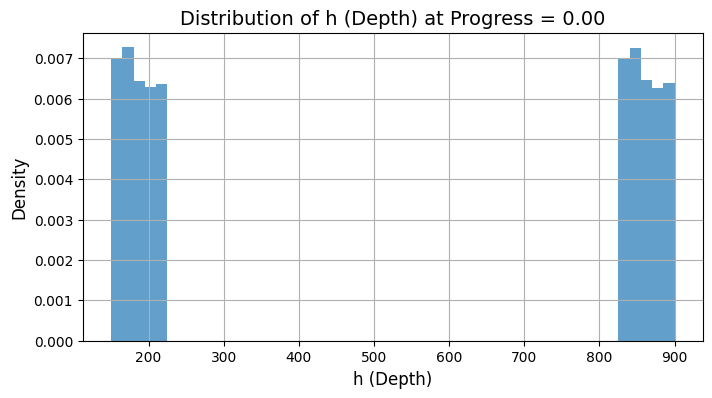

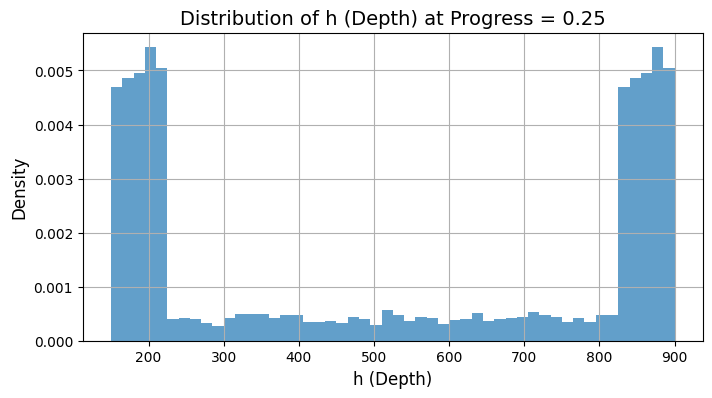

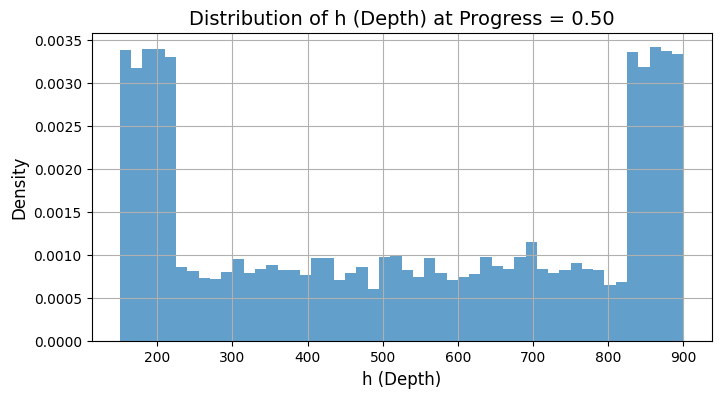

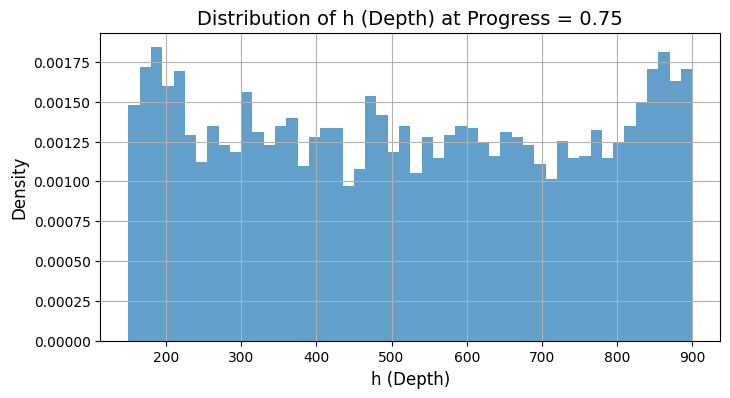

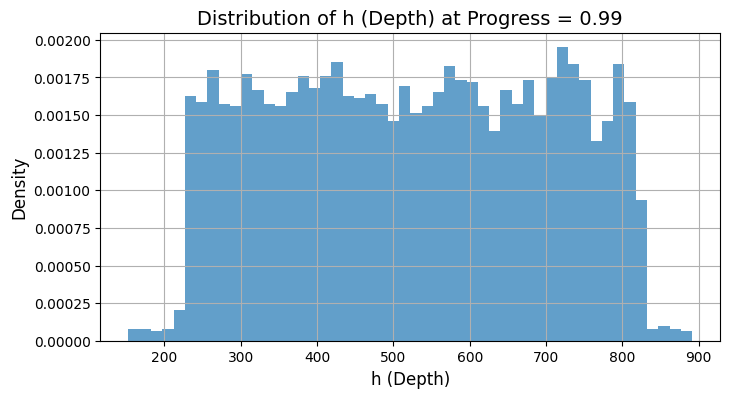

In [5]:
import matplotlib.pyplot as plt

# Example progress values
progress_values = [0.0, 0.25, 0.5, 0.75, .99]

for prog in progress_values:
    key_temp = jax.random.PRNGKey(0)
    key_temp, h_samples = sample_progressive(
        key_temp, 5000, hmin, hmax, h_edge_low, h_edge_high, h_edge_high2, h_center_low, h_center_high, prog
    )
    plt.figure(figsize=(8, 4))
    plt.hist(h_samples, bins=50, density=True, alpha=0.7)
    plt.title(f'Distribution of h (Depth) at Progress = {prog:.2f}', fontsize=14)
    plt.xlabel('h (Depth)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.grid(True)
    plt.show()


# Fin